# EDA

In [174]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset

В связи с тем, что никто не хочет делиться датасетом с реальными данными для opensource проекта, мы будем использовать самый популярный синтетический датасет с kaggle с разметкой фродовых транзакций.

Ссылка на датасет:
https://www.kaggle.com/datasets/ealaxi/paysim1

In [175]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gfgh\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


In [176]:
import os

In [177]:
csv_files = []
_, _, files = list(os.walk(path))[0]
for filename in files:
    if filename.endswith('.csv'):
        csv_files.append(os.path.join(path, filename))

csv_files

['C:\\Users\\gfgh\\.cache\\kagglehub\\datasets\\ealaxi\\paysim1\\versions\\2\\PS_20174392719_1491204439457_log.csv']

In [178]:
import pandas as pd

In [179]:
df = pd.read_csv(csv_files[0])

df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3619775,274,PAYMENT,1320.23,C939681735,1073.00,0.00,M1453721946,0.00,0.00,0,0
5061714,354,CASH_OUT,534442.84,C368811550,690483.00,156040.16,C362384493,1914.05,536356.88,0,0
2038365,180,PAYMENT,340.73,C308672059,0.00,0.00,M2048108025,0.00,0.00,0,0
357832,17,CASH_OUT,207676.29,C1777207938,42101.00,0.00,C2117999483,1751745.91,1959422.21,0,0
4760070,334,CASH_OUT,283972.14,C1185074299,395.00,0.00,C285726916,926737.57,1210709.72,0,0
1352138,137,TRANSFER,142246.80,C668801763,0.00,0.00,C2144030797,6364099.37,6506346.16,0,0
2858350,227,CASH_OUT,306848.98,C718380147,102438.00,0.00,C330440355,210838.53,517687.51,0,0
319100,16,CASH_OUT,82946.94,C1520479629,28909.00,0.00,C1583748955,0.00,82946.94,0,0
4855203,347,CASH_OUT,88217.36,C705457594,1579.00,0.00,C1316106938,214017.87,302235.24,0,0
6187838,569,TRANSFER,176626.77,C1445328479,176626.77,0.00,C1305022941,0.00,0.00,1,0


In [180]:
df = df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], axis=1)

df.sample(10)

,step,type,amount,nameOrig,nameDest,isFraud
4400581,321,CASH_IN,217578.99,C752938759,C1345938153,0
5328229,374,CASH_OUT,566066.17,C581861239,C852475647,0
1228201,133,CASH_OUT,499283.09,C1743809623,C1593703392,0
4251196,306,PAYMENT,19399.58,C1788373713,M1390550026,0
1135579,131,CASH_IN,82097.85,C1380684245,C232694123,0
5961371,406,PAYMENT,25803.76,C29111146,M746354767,0
5591697,394,PAYMENT,582.91,C684655928,M868450226,0
1407324,139,CASH_IN,26320.33,C509882745,C915892101,0
1512827,153,TRANSFER,766200.79,C1908591057,C1502287290,0
753016,38,CASH_OUT,140615.64,C1108361574,C935808590,0


Также мы решили дропнуть следующие фичи: баланс и флаг фрода.

В нашем кейсе нам не будут доступны балансы пользователей, да и в целом они редко доступны, а также создают лишние зависимости в обучении, так что от них мы отказываемся.

FlaggedFraud - это параметр, сильно зависящий от базовых алгоритмов внутри банка или предприятия в общем случае, причем в случае "обычных" алгоритмов он опять создает мультиколлинеарность, так что логично в исследовании подходов для детекции фрода убрать его тоже! Если же мы решим в процессе экспериментов по улучшению качества ответа модели добавить этот параметр, планируется использовать свои подобранные экспертные правила.

## EDA непосредственно

In [181]:
print(f"Размер датасета: {df.shape[0]:,} строк × {df.shape[1]} столбцов")

print("\nТИПЫ ДАННЫХ:")
print(df.dtypes)

print("\nУНИКАЛЬНЫЕ ЗНАЧЕНИЯ В КАЖДОЙ КОЛОНКЕ:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count:,} уникальных значений" +
          (f" ({df[col].unique()[:5]})" if unique_count <= 10 and df[col].dtype == 'object' else ""))

Размер датасета: 6,362,620 строк × 6 столбцов

ТИПЫ ДАННЫХ:
step          int64
type         object
amount      float64
nameOrig     object
nameDest     object
isFraud       int64
dtype: object

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ В КАЖДОЙ КОЛОНКЕ:
step: 743 уникальных значений
type: 5 уникальных значений (['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN'])
amount: 5,316,900 уникальных значений
nameOrig: 6,353,307 уникальных значений
nameDest: 2,722,362 уникальных значений
isFraud: 2 уникальных значений


In [182]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage.round(2)
})

print("Статистика пропущенных значений:")
print(missing_df)

Статистика пропущенных значений:
          Количество пропусков  Процент пропусков
step                         0                0.0
type                         0                0.0
amount                       0                0.0
nameOrig                     0                0.0
nameDest                     0                0.0
isFraud                      0                0.0


In [183]:
import matplotlib.pyplot as plt

Не fraud: 6,354,407 транзакций (99.8709%)
Fraud: 8,213 транзакций (0.1291%)







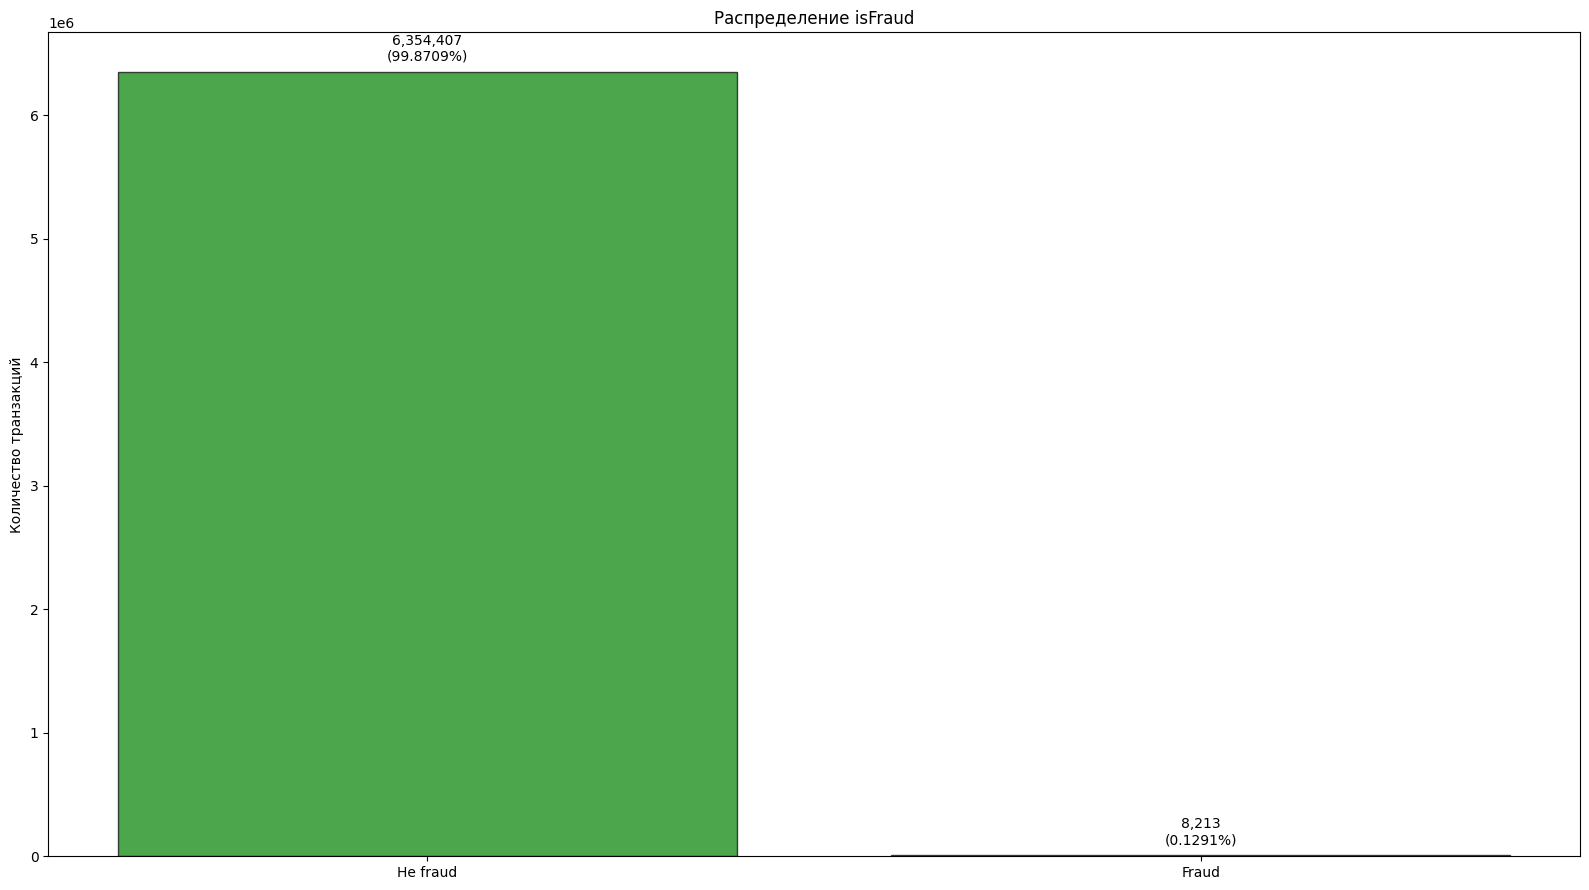

In [184]:
fraud_counts = df['isFraud'].value_counts()
fraud_percentage = df['isFraud'].value_counts(normalize=True) * 100

print(f"Не fraud: {fraud_counts[0]:,} транзакций ({fraud_percentage[0]:.4f}%)")
print(f"Fraud: {fraud_counts[1]:,} транзакций ({fraud_percentage[1]:.4f}%)")
print('\n\n\n\n')

fig, axes = plt.subplots(1, 1, figsize=(16, 9))

ax1 = axes
bars1 = ax1.bar(['Не fraud', 'Fraud'], fraud_counts.values,
                color=['green', 'red'], alpha=0.7, edgecolor='black')
ax1.set_title('Распределение isFraud')
ax1.set_ylabel('Количество транзакций')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + fraud_counts.max()*0.01,
             f'{int(height):,}\n({height/len(df)*100:.4f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [185]:
import numpy as np

Распределение типов транзакций:
1. CASH_OUT: 2,237,500 транзакций (35.17%)
2. PAYMENT: 2,151,495 транзакций (33.81%)
3. CASH_IN: 1,399,284 транзакций (21.99%)
4. TRANSFER: 532,909 транзакций (8.38%)
5. DEBIT: 41,432 транзакций (0.65%)

СВЯЗЬ ТИПОВ ТРАНЗАКЦИЙ С МОШЕННИЧЕСТВОМ (isFraud):





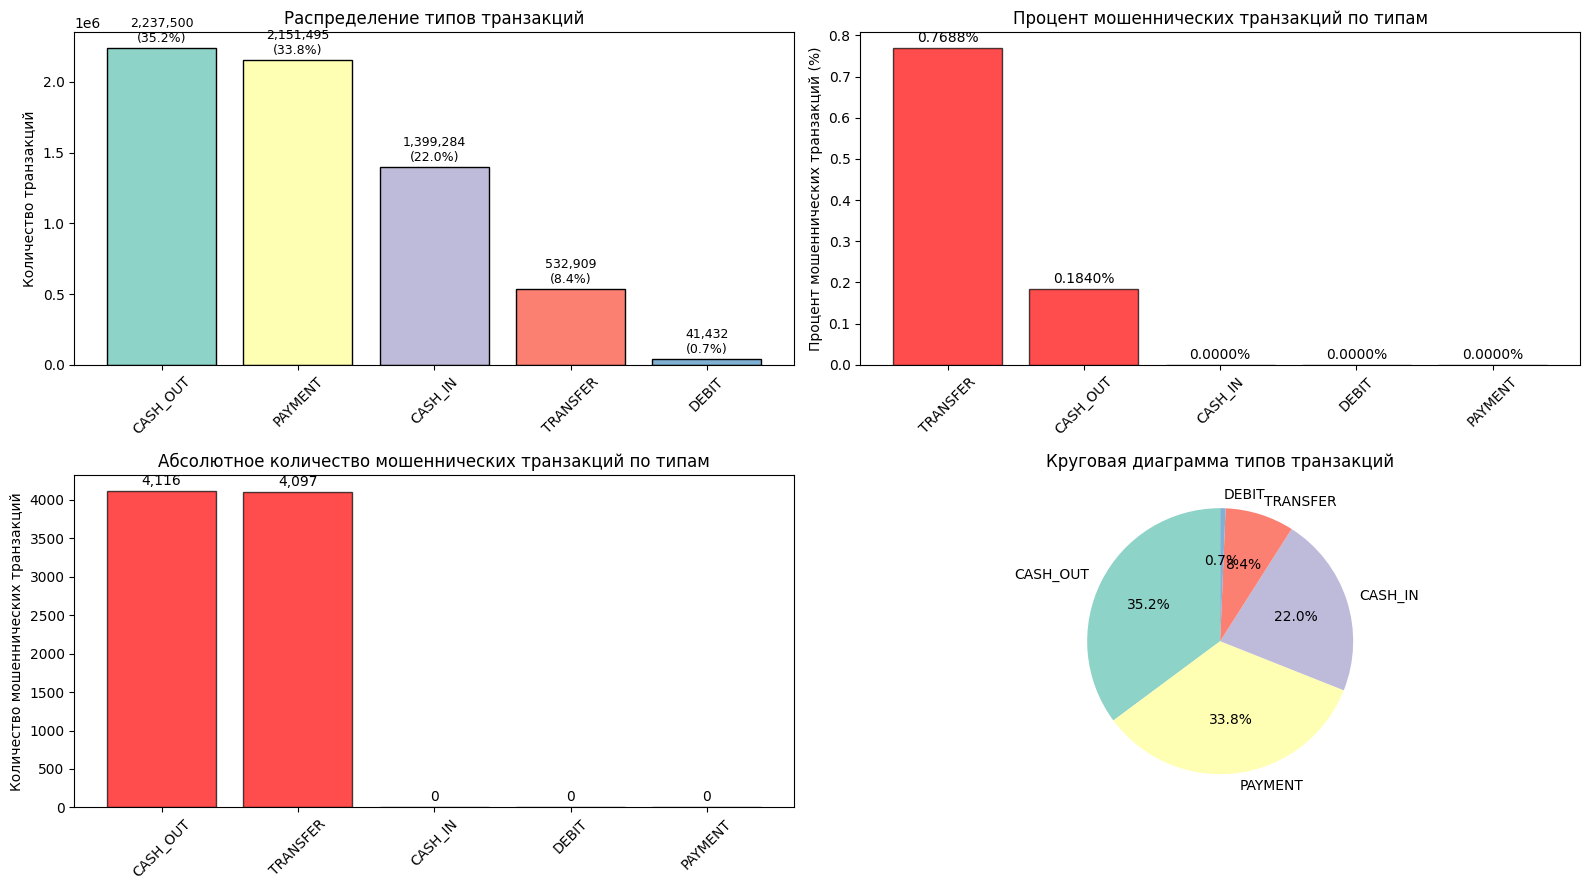

In [186]:
transaction_counts = df['type'].value_counts()
transaction_percentage = df['type'].value_counts(normalize=True) * 100

print("Распределение типов транзакций:")
for i, (ttype, count) in enumerate(transaction_counts.items()):
    print(f"{i+1}. {ttype}: {count:,} транзакций ({transaction_percentage[ttype]:.2f}%)")

print("\nСВЯЗЬ ТИПОВ ТРАНЗАКЦИЙ С МОШЕННИЧЕСТВОМ (isFraud):\n\n\n")

fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum', 'mean'])
fraud_by_type['fraud_percentage'] = fraud_by_type['mean'] * 100
fraud_by_type['total_percentage'] = (fraud_by_type['count'] / len(df)) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 9))

ax1 = axes[0, 0]
colors1 = plt.cm.Set3(np.arange(len(transaction_counts)))
bars1 = ax1.bar(range(len(transaction_counts)), transaction_counts.values,
                color=colors1, edgecolor='black')
ax1.set_title('Распределение типов транзакций')
ax1.set_ylabel('Количество транзакций')
ax1.set_xticks(range(len(transaction_counts)))
ax1.set_xticklabels(transaction_counts.index, rotation=45)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    percentage = transaction_percentage[transaction_counts.index[i]]
    ax1.text(bar.get_x() + bar.get_width()/2., height + transaction_counts.max()*0.01,
             f'{int(height):,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

ax2 = axes[0, 1]
fraud_percent_by_type = fraud_by_type['fraud_percentage'].sort_values(ascending=False)
colors2 = ['red' if x > 0 else 'green' for x in fraud_percent_by_type]
bars2 = ax2.bar(range(len(fraud_percent_by_type)), fraud_percent_by_type.values,
                color=colors2, alpha=0.7, edgecolor='black')
ax2.set_title('Процент мошеннических транзакций по типам')
ax2.set_ylabel('Процент мошеннических транзакций (%)')
ax2.set_xticks(range(len(fraud_percent_by_type)))
ax2.set_xticklabels(fraud_percent_by_type.index, rotation=45)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + fraud_percent_by_type.max()*0.01,
             f'{height:.4f}%', ha='center', va='bottom')

ax3 = axes[1, 0]
fraud_counts_by_type = fraud_by_type['sum'].sort_values(ascending=False)
bars3 = ax3.bar(range(len(fraud_counts_by_type)), fraud_counts_by_type.values,
                color='red', alpha=0.7, edgecolor='black')
ax3.set_title('Абсолютное количество мошеннических транзакций по типам')
ax3.set_ylabel('Количество мошеннических транзакций')
ax3.set_xticks(range(len(fraud_counts_by_type)))
ax3.set_xticklabels(fraud_counts_by_type.index, rotation=45)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + fraud_counts_by_type.max()*0.01,
             f'{int(height):,}', ha='center', va='bottom')

ax4 = axes[1, 1]
ax4.pie(transaction_counts.values, labels=transaction_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors1)
ax4.set_title('Круговая диаграмма типов транзакций')

plt.tight_layout()
plt.show()

Заметим, что только 2 типа транзакций в данном датасете содержат fraud

In [187]:
print("Статистика по сумме транзакции (amount):")
print(df['amount'].describe().round(2))
print('\n\n\n')
fraud_stats = df[df['isFraud'] == 1]['amount'].describe()
non_fraud_stats = df[df['isFraud'] == 0]['amount'].describe()

stats_comparison = pd.DataFrame({
    'Все транзакции': df['amount'].describe(),
    'isFraud=1': fraud_stats,
    'isFraud=0': non_fraud_stats
})
print(stats_comparison.round(2))

Статистика по сумме транзакции (amount):
count     6362620.00
mean       179861.90
std        603858.23
min             0.00
25%         13389.57
50%         74871.94
75%        208721.48
max      92445516.64
Name: amount, dtype: float64




       Все транзакции    isFraud=1    isFraud=0
count      6362620.00      8213.00   6354407.00
mean        179861.90   1467967.30    178197.04
std         603858.23   2404252.95    596236.98
min              0.00         0.00         0.01
25%          13389.57    127091.33     13368.40
50%          74871.94    441423.44     74684.72
75%         208721.48   1517771.48    208364.76
max       92445516.64  10000000.00  92445516.64


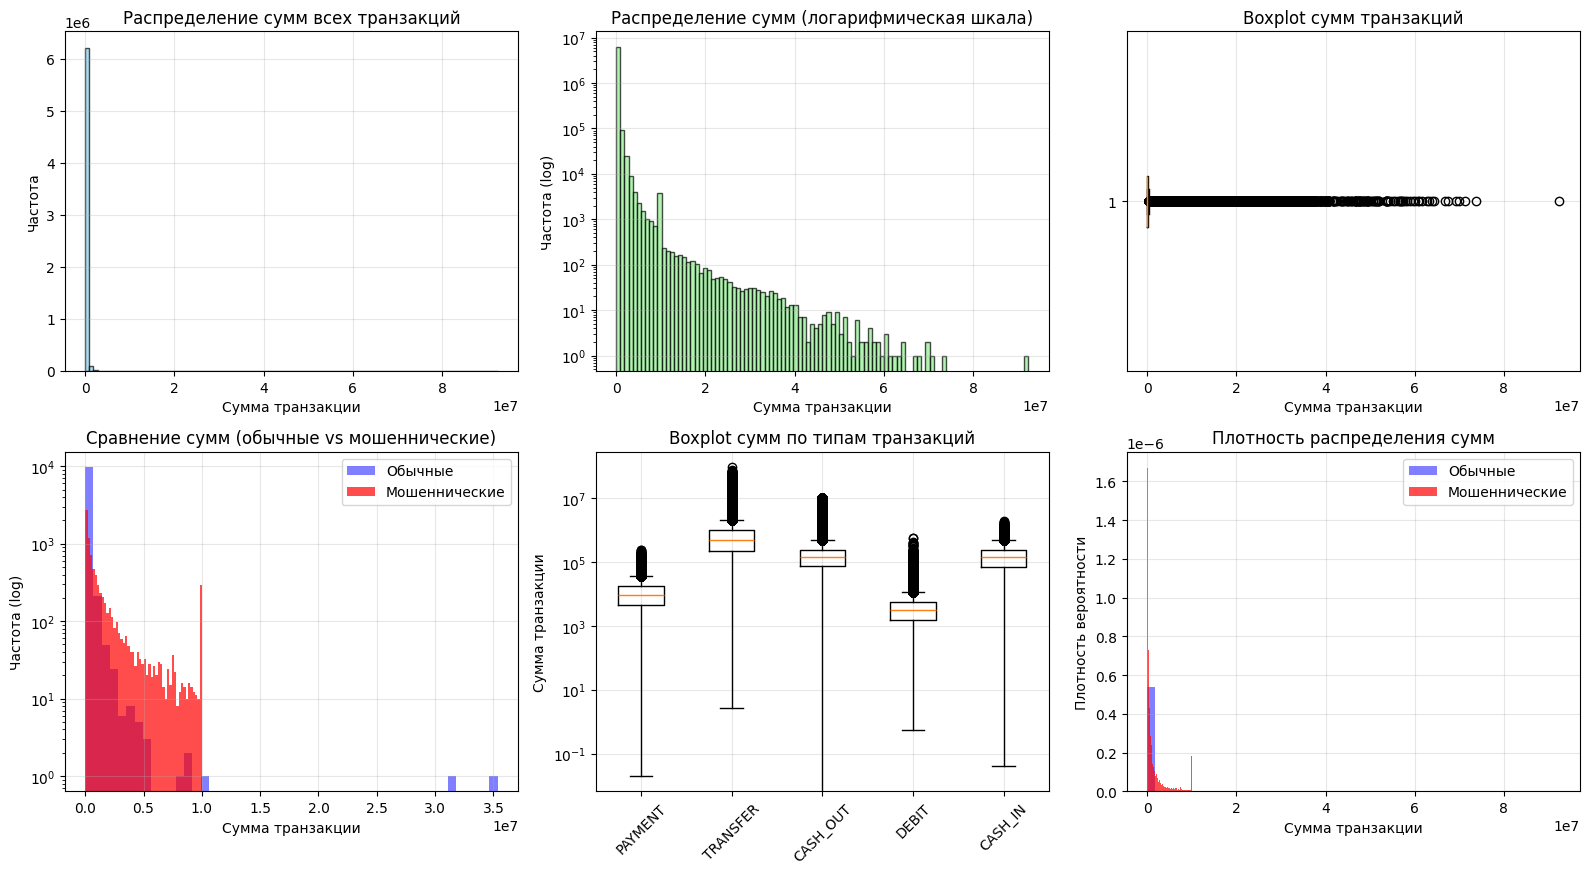

In [188]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

ax1 = axes[0, 0]
ax1.hist(df['amount'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Распределение сумм всех транзакций')
ax1.set_xlabel('Сумма транзакции')
ax1.set_ylabel('Частота')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(df['amount'], bins=100, color='lightgreen', edgecolor='black', alpha=0.7, log=True)
ax2.set_title('Распределение сумм (логарифмическая шкала)')
ax2.set_xlabel('Сумма транзакции')
ax2.set_ylabel('Частота (log)')
ax2.grid(True, alpha=0.3)

ax3 = axes[0, 2]
ax3.boxplot(df['amount'], vert=False)
ax3.set_title('Boxplot сумм транзакций')
ax3.set_xlabel('Сумма транзакции')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 0]
fraud_amounts = df[df['isFraud'] == 1]['amount']
non_fraud_amounts = df[df['isFraud'] == 0]['amount'].sample(10000)
ax4.hist(non_fraud_amounts, bins=50, alpha=0.5, label='Обычные', color='blue', log=True)
ax4.hist(fraud_amounts, bins=50, alpha=0.7, label='Мошеннические', color='red', log=True)
ax4.set_title('Сравнение сумм (обычные vs мошеннические)')
ax4.set_xlabel('Сумма транзакции')
ax4.set_ylabel('Частота (log)')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = axes[1, 1]
transaction_types = df['type'].unique()
amounts_by_type = [df[df['type'] == ttype]['amount'] for ttype in transaction_types]
ax5.boxplot(amounts_by_type, labels=transaction_types)
ax5.set_title('Boxplot сумм по типам транзакций')
ax5.set_ylabel('Сумма транзакции')
ax5.set_xticklabels(transaction_types, rotation=45)
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

ax6 = axes[1, 2]
fraud_amounts = df[df['isFraud'] == 1]['amount']
non_fraud_amounts = df[df['isFraud'] == 0]['amount']
ax6.hist(non_fraud_amounts, bins=50, density=True, alpha=0.5, label='Обычные', color='blue')
ax6.hist(fraud_amounts, bins=50, density=True, alpha=0.7, label='Мошеннические', color='red')
ax6.set_title('Плотность распределения сумм')
ax6.set_xlabel('Сумма транзакции')
ax6.set_ylabel('Плотность вероятности')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [189]:
print(f"Временной диапазон: {df['step'].min()} - {df['step'].max()} шагов")
print(f"Всего уникальных шагов: {df['step'].nunique()}")

transactions_by_step = df['step'].value_counts().sort_index()

print(f"\nМаксимальное количество транзакций за шаг: {transactions_by_step.max():,}")
print(f"Минимальное количество транзакций за шаг: {transactions_by_step.min():,}")
print(f"Среднее количество транзакций за шаг: {transactions_by_step.mean():.0f}")

fraud_by_step = df[df['isFraud'] == 1].groupby('step').size()
print(f"\nМошеннических транзакций всего: {fraud_by_step.sum():,}")
print(f"Шагов с мошенническими транзакциями: {len(fraud_by_step)} из {df['step'].nunique()}")
print(f"Максимум мошеннических транзакций за шаг: {fraud_by_step.max() if len(fraud_by_step) > 0 else 0}")

Временной диапазон: 1 - 743 шагов
Всего уникальных шагов: 743

Максимальное количество транзакций за шаг: 51,352
Минимальное количество транзакций за шаг: 2
Среднее количество транзакций за шаг: 8563

Мошеннических транзакций всего: 8,213
Шагов с мошенническими транзакциями: 741 из 743
Максимум мошеннических транзакций за шаг: 40


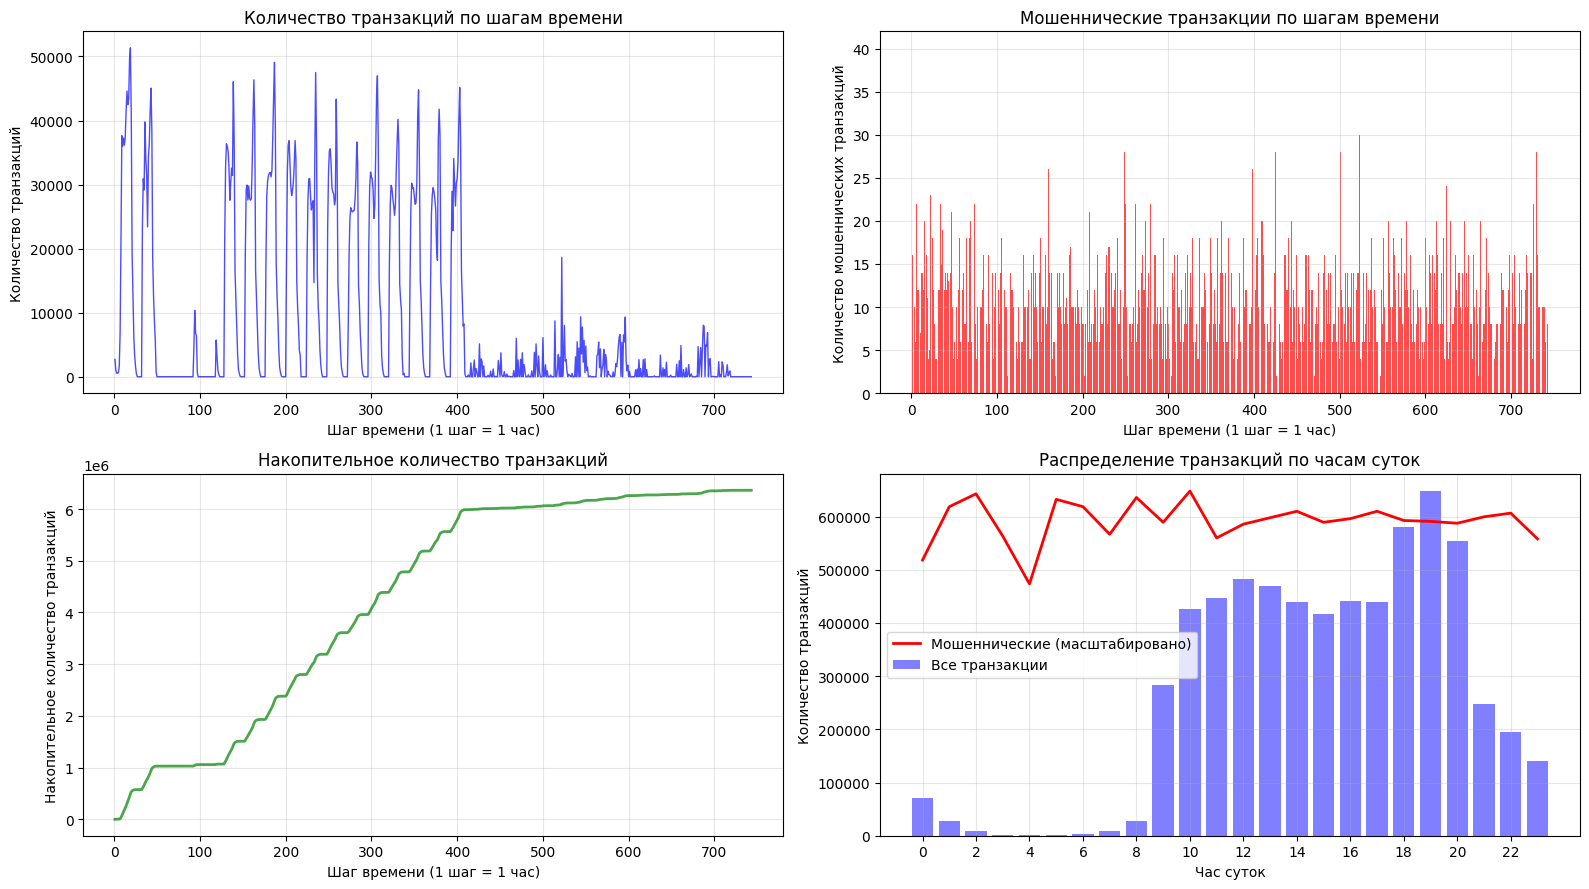

Топ-5 шагов с наибольшим количеством транзакций:
  Шаг 19: 51,352 транзакций
  Шаг 18: 49,579 транзакций
  Шаг 187: 49,083 транзакций
  Шаг 235: 47,491 транзакций
  Шаг 307: 46,968 транзакций

Топ-5 шагов с наибольшим количеством мошеннических транзакций:
  Шаг 212: 40 мошеннических транзакций
  Шаг 523: 30 мошеннических транзакций
  Шаг 249: 28 мошеннических транзакций
  Шаг 387: 28 мошеннических транзакций
  Шаг 425: 28 мошеннических транзакций


In [190]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

ax1 = axes[0, 0]
ax1.plot(transactions_by_step.index, transactions_by_step.values,
         color='blue', alpha=0.7, linewidth=1)
ax1.set_title('Количество транзакций по шагам времени')
ax1.set_xlabel('Шаг времени (1 шаг = 1 час)')
ax1.set_ylabel('Количество транзакций')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
if len(fraud_by_step) > 0:
    ax2.bar(fraud_by_step.index, fraud_by_step.values,
            color='red', alpha=0.7, width=0.8)
ax2.set_title('Мошеннические транзакции по шагам времени')
ax2.set_xlabel('Шаг времени (1 шаг = 1 час)')
ax2.set_ylabel('Количество мошеннических транзакций')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
cumulative_transactions = transactions_by_step.sort_index().cumsum()
ax3.plot(cumulative_transactions.index, cumulative_transactions.values,
         color='green', alpha=0.7, linewidth=2)
ax3.set_title('Накопительное количество транзакций')
ax3.set_xlabel('Шаг времени (1 шаг = 1 час)')
ax3.set_ylabel('Накопительное количество транзакций')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
df['hour_of_day'] = df['step'] % 24
transactions_by_hour = df.groupby('hour_of_day').size()
fraud_by_hour = df[df['isFraud'] == 1].groupby('hour_of_day').size()

ax4.bar(transactions_by_hour.index, transactions_by_hour.values,
        alpha=0.5, label='Все транзакции', color='blue')
if len(fraud_by_hour) > 0:
    ax4.plot(fraud_by_hour.index, fraud_by_hour.values * (transactions_by_hour.max() / fraud_by_hour.max()),
             color='red', linewidth=2, label='Мошеннические (масштабировано)')
ax4.set_title('Распределение транзакций по часам суток')
ax4.set_xlabel('Час суток')
ax4.set_ylabel('Количество транзакций')
ax4.set_xticks(range(0, 24, 2))
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

top_steps = transactions_by_step.nlargest(5)
print("Топ-5 шагов с наибольшим количеством транзакций:")
for step, count in top_steps.items():
    print(f"  Шаг {step}: {count:,} транзакций")

if len(fraud_by_step) > 0:
    top_fraud_steps = fraud_by_step.nlargest(5)
    print("\nТоп-5 шагов с наибольшим количеством мошеннических транзакций:")
    for step, count in top_fraud_steps.items():
        print(f"  Шаг {step}: {count} мошеннических транзакций")

In [191]:
import seaborn as sns

Index(['step', 'amount', 'nameOrig', 'nameDest', 'isFraud', 'hour_of_day',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')
                 step  amount  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
step           1.0000  0.0224        0.0041        -0.0129      0.0029   
amount         0.0224  1.0000       -0.0096        -0.0044     -0.0234   
type_CASH_IN   0.0041 -0.0096        1.0000        -0.3910     -0.0430   
type_CASH_OUT -0.0129 -0.0044       -0.3910         1.0000     -0.0596   
type_DEBIT     0.0029 -0.0234       -0.0430        -0.0596      1.0000   
type_PAYMENT   0.0049 -0.1974       -0.3795        -0.5264     -0.0579   
type_TRANSFER  0.0069  0.3659       -0.1605        -0.2227     -0.0245   
isFraud        0.0316  0.0767       -0.0191         0.0113     -0.0029   

               type_PAYMENT  type_TRANSFER  isFraud  
step                 0.0049         0.0069   0.0316  
amount              -0.1974      

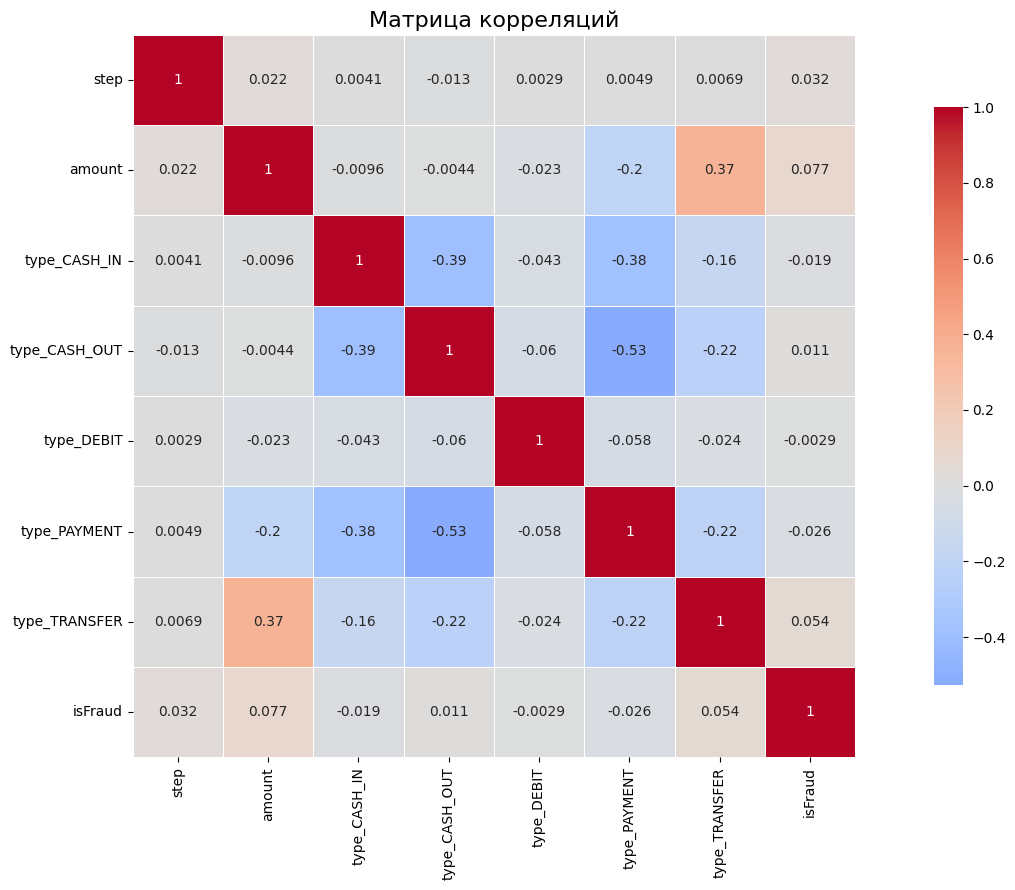

In [192]:
corr_df = df.copy()

corr_df = pd.get_dummies(corr_df, columns=['type'], prefix='type')
print(corr_df.columns)

numeric_cols = ['step', 'amount','type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT','type_TRANSFER', 'isFraud']
correlation_matrix = corr_df[numeric_cols].corr()

print(correlation_matrix.round(4))

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=16)
plt.tight_layout()
plt.show()

Тут видно, что у фрода сильнее всего выражена корреляция с суммой и очень сильно выражена с некоторыми отдельными типами, что связано, вероятно, с тем, что у нас фрод есть только среди двух типов транзакций

## Выводы

Краткий вывод по EDA:

1. Датасет очень большой — 6.36 млн транзакций, при этом мошенничество встречается крайне редко: всего 8 213 случаев (0.13%), что сразу говорит о сильном дисбалансе классов.
2. Основная масса операций — `CASH_OUT` (35%) и `PAYMENT` (34%), но мошенничество сосредоточено почти исключительно в `TRANSFER` и `CASH_OUT`: у `TRANSFER` ~0.77% мошеннических операций, у `CASH_OUT` ~0.18%, в остальных типах — практически ноль.
3. Мошеннические транзакции заметно крупнее по суммам: медиана ~441 тыс. против ~75 тыс. у обычных, а среднее значение почти в 8 раз выше (1.47 млн vs 178 тыс.).
4. Распределение сумм сильно скошено вправо: большинство операций небольшие, но есть редкие транзакции до 92 млн, что важно учитывать при моделировании (лог-шкала, робастные метрики).
5. Во времени операции распределены неравномерно: есть пики до 51 тыс. транзакций в час, при этом мошенничество присутствует почти на всех шагах времени (741 из 743), но в небольшом количестве — максимум 40 случаев в час.
6. По часам суток виден общий суточный ритм транзакций, однако мошенничество не привязано к одному конкретному часу, а распределено относительно равномерно.
7. Имена отправителей и получателей почти всегда уникальны, поэтому они скорее идентификаторы, чем признаки, и полезны в агрегатах или графовых признаках.
8. В целом, ключевые сигналы мошенничества — это тип операции (`TRANSFER`/`CASH_OUT`), аномально большие суммы и поведенческие паттерны во времени, а не просто частота операций.

# BASELINE

## CatBoostClassifier

В качестве базовой модельки возьмем CatBoostClassifier, он хорошо работает с категориальными признаками и с дисбалансом классов

Сэмплируем датасет: сделаем соотношение фрода к нефроду как 1:19. 

In [193]:
df_fraud = df[df["isFraud"] == 1]
df_nonfraud = df[df["isFraud"] == 0]


n_nonfraud = min(len(df_nonfraud), 19 * len(df_fraud))

df_nonfraud_sampled = df_nonfraud.sample(
    n=n_nonfraud,
    random_state=42
)

df_balanced = pd.concat([df_fraud, df_nonfraud_sampled]) \
               .sample(frac=1, random_state=42) \
               .reset_index(drop=True)

print(df_balanced["isFraud"].value_counts())

isFraud
0    156047
1      8213
Name: count, dtype: int64


Выделим фичи и таргет в каждом из датасетов

In [194]:
features = [
    "step",
    "type",
    "amount",
    "nameOrig",
    "nameDest"
]

target = "isFraud"

X = df_balanced[features]
y = df_balanced[target]

Разделим на тестовую и тренировочную выборки

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Обучим модель с базовыми гиперпараметрами

In [196]:
!pip install catboost


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [197]:
from catboost import CatBoostClassifier

cat_features = [
    X.columns.get_loc(col)
    for col in ["type", "nameOrig", "nameDest"]
]

model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=50
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

0:	test: 0.9403725	best: 0.9403725 (0)	total: 77.2ms	remaining: 23.1s
50:	test: 0.9604105	best: 0.9604599 (49)	total: 3.35s	remaining: 16.4s
100:	test: 0.9636775	best: 0.9636980 (96)	total: 6.84s	remaining: 13.5s
150:	test: 0.9665653	best: 0.9665653 (150)	total: 10.4s	remaining: 10.3s
200:	test: 0.9680759	best: 0.9680858 (199)	total: 14s	remaining: 6.91s
250:	test: 0.9692921	best: 0.9692944 (249)	total: 17.7s	remaining: 3.46s
299:	test: 0.9700031	best: 0.9700037 (298)	total: 21.4s	remaining: 0us

bestTest = 0.9700037271
bestIteration = 298

Shrink model to first 299 iterations.


Получим все предсказания

In [198]:
import numpy as np

# вероятности класса "фрод" (1)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# бинарные предсказания (порог 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

Посчитаем все метрики 

In [199]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score
)

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC   : {roc_auc:.4f}")
print(f"PR-AUC    : {pr_auc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

ROC-AUC   : 0.9700
PR-AUC    : 0.7849
Precision : 0.8624
Recall    : 0.5685
F1-score  : 0.6853


## LSTM

Тут обсудим и рассмомтрим подход с использованием семейства LSTM, что позволит нам акцентировать внимание модели на времени/последовательности транзакций для определения фрода. Для `baseline` мы будем использовать самый базовый подход — сгруппируем транзакции по пользователю и кинем в модельку!

In [200]:
df['amount_log'] = np.log1p(df['amount'])
df_sorted = df.sort_values(['nameOrig', 'step'])

type_dummies = pd.get_dummies(df_sorted['type'], dtype=np.float32)

features = np.hstack([type_dummies.values, df_sorted[['amount_log']].values])

user_groups = df_sorted.groupby('nameOrig').indices
sequences = {user: features[idx] for user, idx in user_groups.items()}
sequences = pd.Series(sequences)

labels = df_sorted.groupby('nameOrig')['isFraud'].max().loc[sequences.index].values

print(f"Пользователей: {len(sequences)}")
print(f"Фродовых пользователей: {labels.sum()} ({labels.mean()*100:.2f}%)")

Пользователей: 6353307
Фродовых пользователей: 8213 (0.13%)


Базово мы для такого подхода хотим одинаковую длину последовательностей, по которым классифицировать, поэтому в контексте бейзлайна просто все выровняем на 50. Большие - обрежем, маленькие - дополним шумом.

Данные так немного потеряем, немного попортим, решать эту проблему будем уже на более полноценном исследовании ☺

In [201]:
from tqdm import tqdm

In [202]:
max_len = 50

def pad_sequence(seq, max_length):
    if len(seq) > max_length:
        return seq[-max_length:]
    else:
        return np.pad(seq, ((max_length - len(seq), 0), (0, 0)), mode='constant')

X_padded = np.array([pad_sequence(seq, max_len) for seq in tqdm(sequences)])
y = labels

print(f"Форма данных: {X_padded.shape}")
print(f"Форма меток: {y.shape}")

100%|██████████| 6353307/6353307 [01:25<00:00, 74517.91it/s]


Форма данных: (6353307, 50, 6)
Форма меток: (6353307,)


In [203]:
from sklearn.model_selection import train_test_split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.3, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3557851, 50, 6), (3557851,)
Test: (1905993, 50, 6), (1905993,)


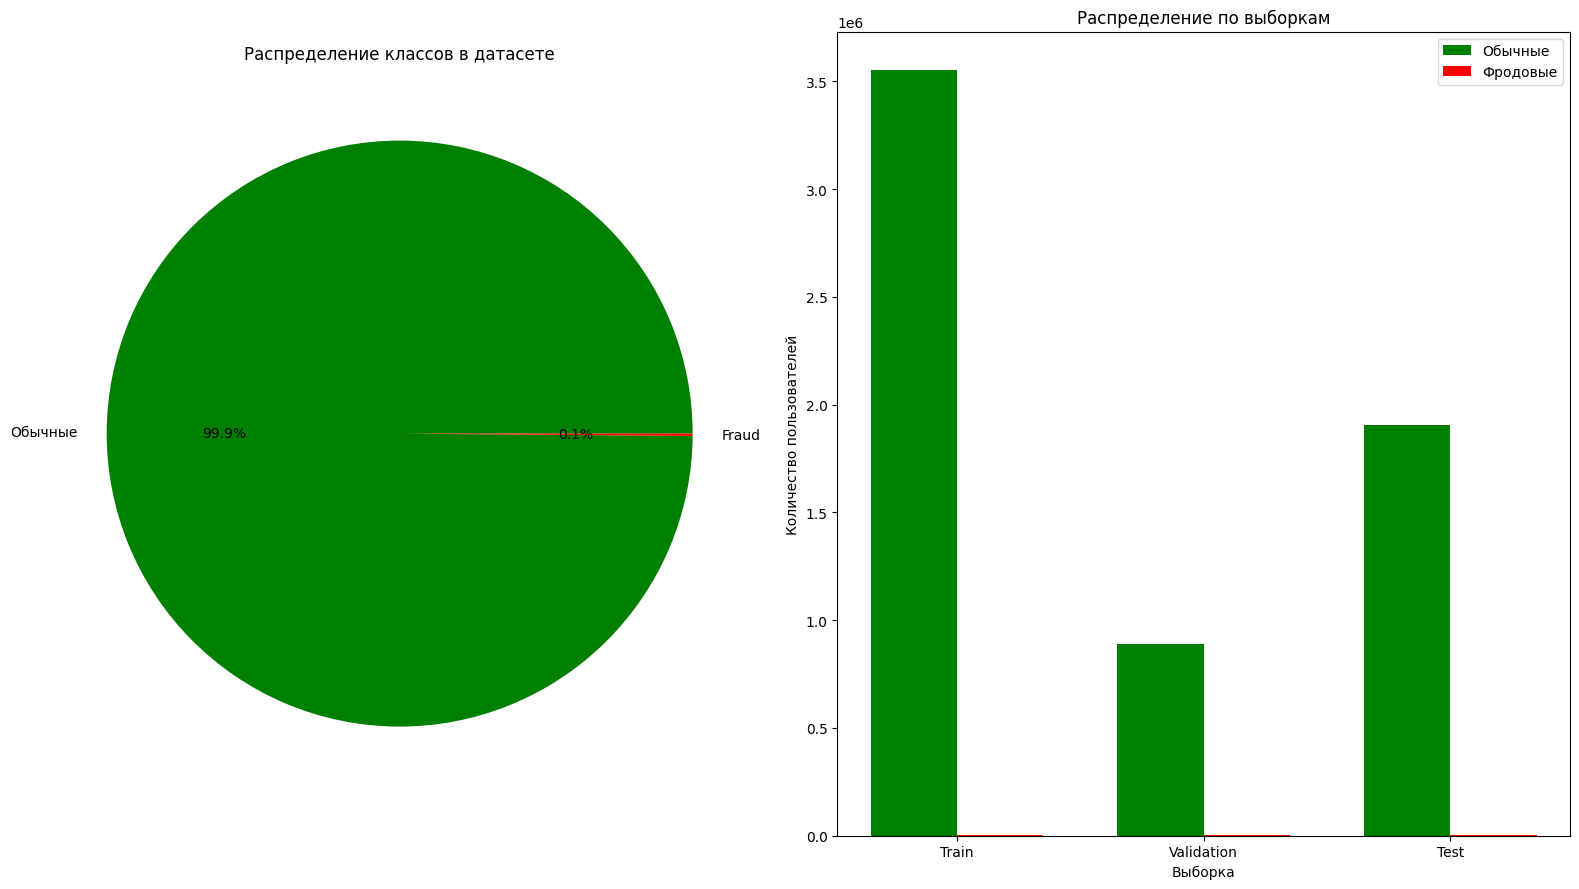

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fraud_count = sum(y)
non_fraud_count = len(y) - fraud_count
ax1.pie([non_fraud_count, fraud_count],
        labels=['Обычные', 'Fraud'],
        autopct='%1.1f%%',
        colors=['green', 'red'])
ax1.set_title('Распределение классов в датасете')

splits = ['Train', 'Validation', 'Test']
fraud_counts = [sum(y_train), sum(y_val), sum(y_test)]
total_counts = [len(y_train), len(y_val), len(y_test)]
non_fraud_counts = [total - fraud for total, fraud in zip(total_counts, fraud_counts)]

x = np.arange(len(splits))
width = 0.35

ax2.bar(x - width/2, non_fraud_counts, width, label='Обычные', color='green')
ax2.bar(x + width/2, fraud_counts, width, label='Фродовые', color='red')
ax2.set_xlabel('Выборка')
ax2.set_ylabel('Количество пользователей')
ax2.set_title('Распределение по выборкам')
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.legend()

plt.tight_layout()
plt.show()

In [206]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [207]:
# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
print(f"Доступно GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Название GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Используемое устройство: cuda
Доступно GPU: True
Название GPU: NVIDIA GeForce RTX 4070 SUPER
Память GPU: 12.88 GB


In [208]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=256, output_size=1, num_layers=2, attention_heads=8):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.attention_heads = attention_heads

        self.embedding = nn.Linear(input_size, 64)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=attention_heads,
            dropout=0.2,
            batch_first=True
        )
        self.attention_weights = None

        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attention=False):
        x_embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(x_embedded)
        attn_out, attn_weights = self.attention(
            lstm_out, lstm_out, lstm_out,
            need_weights=return_attention
        )
        if return_attention:
            self.attention_weights = attn_weights.detach().cpu()
        lstm_out = lstm_out + attn_out
        last_output = lstm_out[:, -1, :]
        output = self.output_layer(last_output)

        return output, hidden

In [209]:
def prepare_data_for_pytorch(X_train, X_val, X_test, y_train, y_val, y_test):
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)

    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Размер батча: {batch_size}")
    print(f"Количество батчей в train: {len(train_loader)}")
    print(f"Количество батчей в val: {len(val_loader)}")
    print(f"Количество батчей в test: {len(test_loader)}")

    return train_loader, val_loader, test_loader

In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

In [211]:
def calculate_metrics(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except:
        auc = 0.0

    return accuracy, precision, recall, auc

In [212]:
def train_model_with_testing(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, test_every=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    
    epoch_test_metrics = {}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        train_probs = []
        
        for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Train'):
            optimizer.zero_grad()
            
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = torch.sigmoid(outputs).detach()
            preds_class = (preds > 0.5).float()
            
            train_preds.extend(preds_class.cpu().numpy())
            train_labels.extend(batch_y.cpu().numpy())
            train_probs.extend(preds.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        accuracy, precision, recall, auc = calculate_metrics(
            np.array(train_labels).flatten(),
            np.array(train_preds).flatten(),
            np.array(train_probs).flatten()
        )
        
        train_metrics['accuracy'].append(accuracy)
        train_metrics['precision'].append(precision)
        train_metrics['recall'].append(recall)
        train_metrics['auc'].append(auc)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        val_probs = []
        
        with torch.no_grad():
            for batch_X, batch_y in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Val'):
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()
                
                val_preds.extend(preds_class.cpu().numpy())
                val_labels.extend(batch_y.cpu().numpy())
                val_probs.extend(preds.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        accuracy, precision, recall, auc = calculate_metrics(
            np.array(val_labels).flatten(),
            np.array(val_preds).flatten(),
            np.array(val_probs).flatten()
        )
        
        val_metrics['accuracy'].append(accuracy)
        val_metrics['precision'].append(precision)
        val_metrics['recall'].append(recall)
        val_metrics['auc'].append(auc)
        
        if (epoch + 1) % test_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"\n{'='*60}")
            print(f"ТЕСТИРОВАНИЕ НА ЭПОХЕ {epoch+1}:")
            print(f"{'='*60}")
            
            model.eval()
            test_loss = 0.0
            test_preds = []
            test_labels = []
            test_probs = []
            
            with torch.no_grad():
                for batch_X, batch_y in tqdm(test_loader, desc='Testing on Test Set'):
                    outputs, _ = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
                    
                    preds = torch.sigmoid(outputs)
                    preds_class = (preds > 0.5).float()
                    
                    test_preds.extend(preds_class.cpu().numpy())
                    test_labels.extend(batch_y.cpu().numpy())
                    test_probs.extend(preds.cpu().numpy())
            
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            
            accuracy, precision, recall, auc = calculate_metrics(
                np.array(test_labels).flatten(),
                np.array(test_preds).flatten(),
                np.array(test_probs).flatten()
            )
            
            test_metrics['accuracy'].append(accuracy)
            test_metrics['precision'].append(precision)
            test_metrics['recall'].append(recall)
            test_metrics['auc'].append(auc)
            
            epoch_test_metrics[epoch + 1] = {
                'loss': test_loss,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'auc': auc
            }
            
            print(f"Test Loss: {test_loss:.4f}, Acc: {accuracy:.4f}, "
                  f"Prec: {precision:.4f}, Rec: {recall:.4f}, AUC: {auc:.4f}")
            print(f"{'='*60}\n")
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Acc: {train_metrics["accuracy"][-1]:.4f}, '
              f'Prec: {train_metrics["precision"][-1]:.4f}, Rec: {train_metrics["recall"][-1]:.4f}, '
              f'AUC: {train_metrics["auc"][-1]:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Acc: {val_metrics["accuracy"][-1]:.4f}, '
              f'Prec: {val_metrics["precision"][-1]:.4f}, Rec: {val_metrics["recall"][-1]:.4f}, '
              f'AUC: {val_metrics["auc"][-1]:.4f}')
        print('-' * 80)
    
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics, epoch_test_metrics

In [213]:
def train_model_with_testing(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, test_every=10, class_weights=None):
    if class_weights is None:
        class_weights = [1.0, 1.0]
    
    device = next(model.parameters()).device
    pos_weight = torch.tensor([class_weights[1] / class_weights[0]], device=device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}
    
    epoch_test_metrics = {}
    
    print(f"Using class weights: negative={class_weights[0]:.2f}, positive={class_weights[1]:.2f}")
    print(f"BCEWithLogitsLoss pos_weight: {pos_weight.item():.2f}")
    print('-' * 80)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        train_probs = []
        
        for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Train'):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = torch.sigmoid(outputs).detach()
            preds_class = (preds > 0.5).float()
            
            train_preds.extend(preds_class.cpu().numpy())
            train_labels.extend(batch_y.cpu().numpy())
            train_probs.extend(preds.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        accuracy, precision, recall, auc = calculate_metrics(
            np.array(train_labels).flatten(),
            np.array(train_preds).flatten(),
            np.array(train_probs).flatten()
        )
        
        train_metrics['accuracy'].append(accuracy)
        train_metrics['precision'].append(precision)
        train_metrics['recall'].append(recall)
        train_metrics['auc'].append(auc)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        val_probs = []
        
        with torch.no_grad():
            for batch_X, batch_y in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Val'):
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()
                
                val_preds.extend(preds_class.cpu().numpy())
                val_labels.extend(batch_y.cpu().numpy())
                val_probs.extend(preds.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        accuracy, precision, recall, auc = calculate_metrics(
            np.array(val_labels).flatten(),
            np.array(val_preds).flatten(),
            np.array(val_probs).flatten()
        )
        
        val_metrics['accuracy'].append(accuracy)
        val_metrics['precision'].append(precision)
        val_metrics['recall'].append(recall)
        val_metrics['auc'].append(auc)
        
        if (epoch + 1) % test_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"\n{'='*60}")
            print(f"ТЕСТИРОВАНИЕ НА ЭПОХЕ {epoch+1}:")
            print(f"{'='*60}")
            
            model.eval()
            test_loss = 0.0
            test_preds = []
            test_labels = []
            test_probs = []
            
            with torch.no_grad():
                for batch_X, batch_y in tqdm(test_loader, desc='Testing on Test Set'):
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)
                    
                    outputs, _ = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
                    
                    preds = torch.sigmoid(outputs)
                    preds_class = (preds > 0.5).float()
                    
                    test_preds.extend(preds_class.cpu().numpy())
                    test_labels.extend(batch_y.cpu().numpy())
                    test_probs.extend(preds.cpu().numpy())
            
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            
            accuracy, precision, recall, auc = calculate_metrics(
                np.array(test_labels).flatten(),
                np.array(test_preds).flatten(),
                np.array(test_probs).flatten()
            )
            
            test_metrics['accuracy'].append(accuracy)
            test_metrics['precision'].append(precision)
            test_metrics['recall'].append(recall)
            test_metrics['auc'].append(auc)
            
            epoch_test_metrics[epoch + 1] = {
                'loss': test_loss,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'auc': auc
            }
            
            print(f"Test Loss: {test_loss:.4f}, Acc: {accuracy:.4f}, "
                  f"Prec: {precision:.4f}, Rec: {recall:.4f}, AUC: {auc:.4f}")
            print(f"{'='*60}\n")
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Acc: {train_metrics["accuracy"][-1]:.4f}, '
              f'Prec: {train_metrics["precision"][-1]:.4f}, Rec: {train_metrics["recall"][-1]:.4f}, '
              f'AUC: {train_metrics["auc"][-1]:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Acc: {val_metrics["accuracy"][-1]:.4f}, '
              f'Prec: {val_metrics["precision"][-1]:.4f}, Rec: {val_metrics["recall"][-1]:.4f}, '
              f'AUC: {val_metrics["auc"][-1]:.4f}')
        print('-' * 80)
    
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics, epoch_test_metrics

In [214]:
def plot_test_metrics_by_epoch(epoch_test_metrics):
    epochs = list(epoch_test_metrics.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 9))
    
    accuracies = [epoch_test_metrics[epoch]['accuracy'] for epoch in epochs]
    axes[0, 0].plot(epochs, accuracies, 'o-', linewidth=2, markersize=8, color='blue')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy на тестовой выборке по эпохам')
    axes[0, 0].grid(True, alpha=0.3)
    
    precisions = [epoch_test_metrics[epoch]['precision'] for epoch in epochs]
    recalls = [epoch_test_metrics[epoch]['recall'] for epoch in epochs]
    
    axes[0, 1].plot(epochs, precisions, 'o-', linewidth=2, markersize=8, label='Precision', color='green')
    axes[0, 1].plot(epochs, recalls, 's-', linewidth=2, markersize=8, label='Recall', color='red')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Значение')
    axes[0, 1].set_title('Precision и Recall на тестовой выборке')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    aucs = [epoch_test_metrics[epoch]['auc'] for epoch in epochs]
    axes[1, 0].plot(epochs, aucs, 'o-', linewidth=2, markersize=8, color='purple')
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('AUC на тестовой выборке по эпохам')
    axes[1, 0].grid(True, alpha=0.3)
    
    losses = [epoch_test_metrics[epoch]['loss'] for epoch in epochs]
    axes[1, 1].plot(epochs, losses, 'o-', linewidth=2, markersize=8, color='orange')
    axes[1, 1].set_xlabel('Эпоха')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Loss на тестовой выборке по эпохам')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    for epoch in sorted(epochs):
        metrics = epoch_test_metrics[epoch]
        print(f"{epoch:<8} {metrics['loss']:<10.4f} {metrics['accuracy']:<10.4f} "
              f"{metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['auc']:<10.4f}")
    
    best_auc_epoch = max(epoch_test_metrics.items(), key=lambda x: x[1]['auc'])[0]
    best_acc_epoch = max(epoch_test_metrics.items(), key=lambda x: x[1]['accuracy'])[0]
    
    print("\n" + "="*80)
    print("ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print("="*80)
    print(f"Лучший AUC: {epoch_test_metrics[best_auc_epoch]['auc']:.4f} на эпохе {best_auc_epoch}")
    print(f"Лучшая Accuracy: {epoch_test_metrics[best_acc_epoch]['accuracy']:.4f} на эпохе {best_acc_epoch}")
    
    return best_auc_epoch, best_acc_epoch

In [215]:
def plot_training_results(train_losses, val_losses, train_metrics, val_metrics):
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))

    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(train_metrics['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(val_metrics['accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(train_metrics['precision'], label='Train Precision', linewidth=2)
    axes[0, 2].plot(val_metrics['precision'], label='Val Precision', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(train_metrics['recall'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(val_metrics['recall'], label='Val Recall', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(train_metrics['auc'], label='Train AUC', linewidth=2)
    axes[1, 1].plot(val_metrics['auc'], label='Val AUC', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].set_title('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].axis('off')
    final_text = f"Final Validation Metrics:\n"
    final_text += f"Accuracy: {val_metrics['accuracy'][-1]:.4f}\n"
    final_text += f"Precision: {val_metrics['precision'][-1]:.4f}\n"
    final_text += f"Recall: {val_metrics['recall'][-1]:.4f}\n"
    final_text += f"AUC: {val_metrics['auc'][-1]:.4f}\n\n"
    final_text += f"Train/Val Ratio:\n"
    final_text += f"Loss: {train_losses[-1]/val_losses[-1]:.2f}\n"
    final_text += f"Accuracy: {train_metrics['accuracy'][-1]/val_metrics['accuracy'][-1]:.2f}"

    axes[1, 2].text(0.1, 0.5, final_text, fontsize=12,
                   verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

In [216]:
def test_model(model, test_loader):
    model.eval()

    test_preds = []
    test_labels = []
    test_probs = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            outputs, _ = model(batch_X)
            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            test_preds.extend(preds_class.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
            test_probs.extend(preds.cpu().numpy())

    test_labels = np.array(test_labels).flatten()
    test_preds = np.array(test_preds).flatten()
    test_probs = np.array(test_probs).flatten()

    accuracy, precision, recall, auc = calculate_metrics(
        test_labels, test_preds, test_probs
    )

    print("\n" + "="*80)
    print("TEST SET RESULTS:")
    print("="*80)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"F1-Score:  {2 * precision * recall / (precision + recall + 1e-8):.4f}")

    cm = confusion_matrix(test_labels, test_preds)

    fig, axes = plt.subplots(1, 2, figsize=(16, 9))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Not Fraud', 'Fraud'])
    disp.plot(cmap='Blues', ax=axes[0], values_format='d')
    axes[0].set_title('Confusion Matrix - Test Set')

    fpr, tpr, _ = roc_curve(test_labels, test_probs)

    axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', linewidth=2, color='darkorange')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1, alpha=0.5)
    axes[1].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve - Test Set')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, auc

In [217]:
train_loader, val_loader, test_loader = prepare_data_for_pytorch(
    X_train, X_val, X_test, y_train, y_val, y_test
)

Размер батча: 64
Количество батчей в train: 55592
Количество батчей в val: 13898
Количество батчей в test: 29782


In [218]:
model = AttentionLSTM(
    input_size=6,
    hidden_size=256,
    output_size=1,
    num_layers=2,
    attention_heads=8
).to(device)

In [168]:
num_epochs = 20  
learning_rate = 0.001
test_every = 5

train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics, epoch_test_metrics = train_model_with_testing(
    model, 
    train_loader, 
    val_loader,
    test_loader,
    num_epochs=num_epochs, 
    learning_rate=learning_rate,
    test_every=test_every
)

Using class weights: negative=1.00, positive=1.00
BCEWithLogitsLoss pos_weight: 1.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 590.94it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 576.89it/s]


Test Loss: 0.1444, Acc: 0.9500, Prec: 0.0000, Rec: 0.0000, AUC: 0.8876

Epoch 1/20:
  Train Loss: 0.1443, Acc: 0.9500, Prec: 0.5034, Rec: 0.0161, AUC: 0.8845
  Val Loss: 0.1441, Acc: 0.9500, Prec: 0.0000, Rec: 0.0000, AUC: 0.8851
--------------------------------------------------------------------------------


Epoch 2/20 - Train:  27%|██▋       | 383/1438 [00:01<00:04, 213.24it/s]


KeyboardInterrupt: 

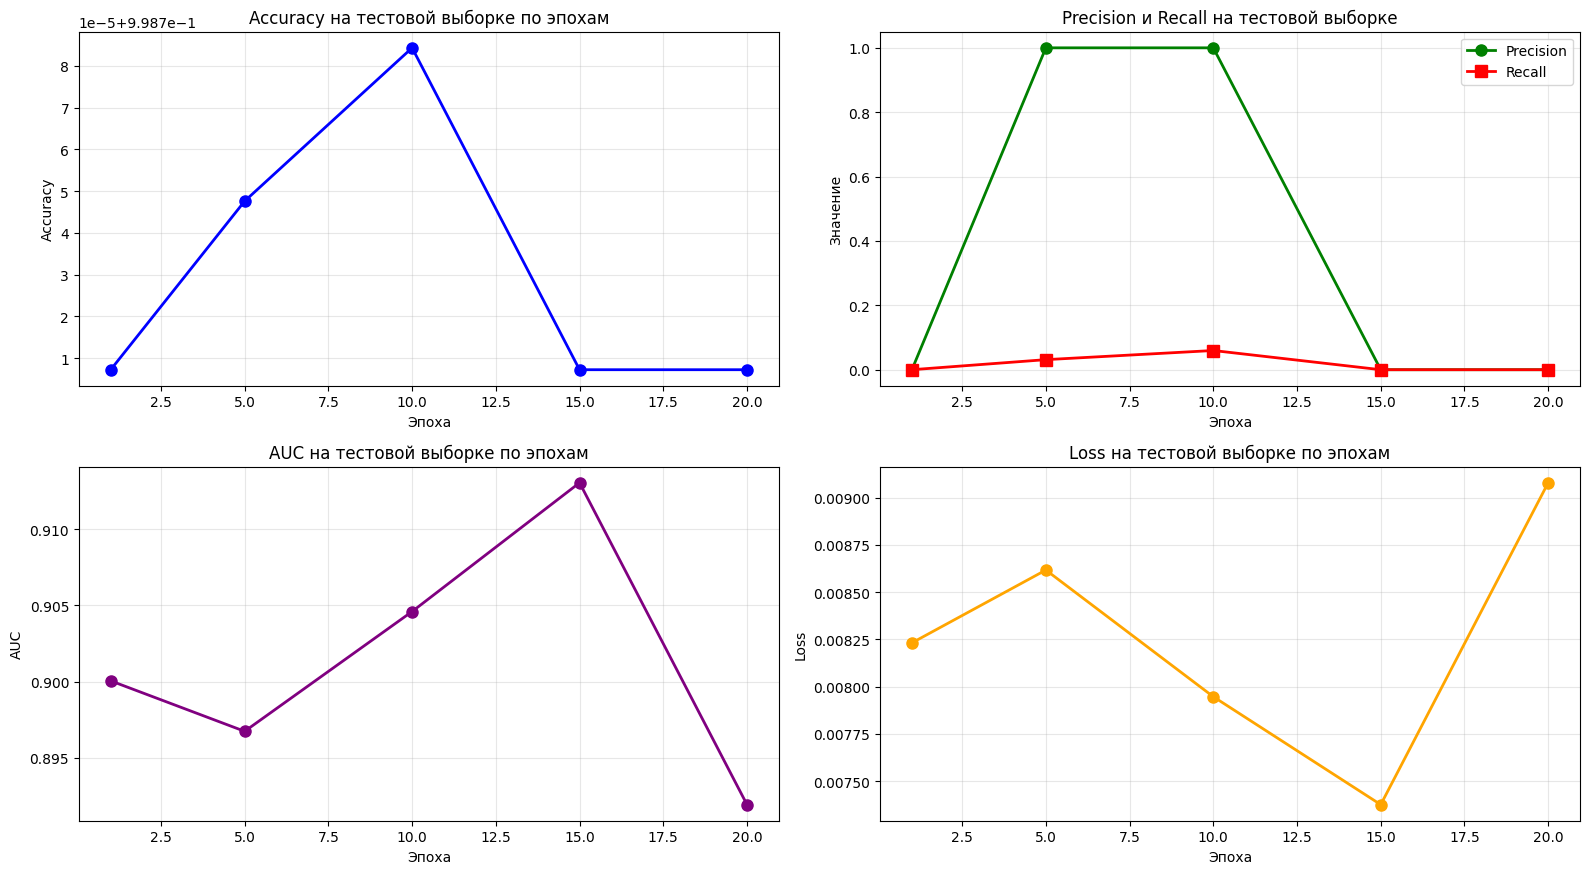

1        0.0082     0.9987     0.0000     0.0000     0.9000    
5        0.0086     0.9987     1.0000     0.0312     0.8967    
10       0.0079     0.9988     1.0000     0.0597     0.9046    
15       0.0074     0.9987     0.0000     0.0000     0.9131    
20       0.0091     0.9987     0.0000     0.0000     0.8919    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.9131 на эпохе 15
Лучшая Accuracy: 0.9988 на эпохе 10


In [ ]:
best_auc_epoch, best_acc_epoch = plot_test_metrics_by_epoch(epoch_test_metrics)

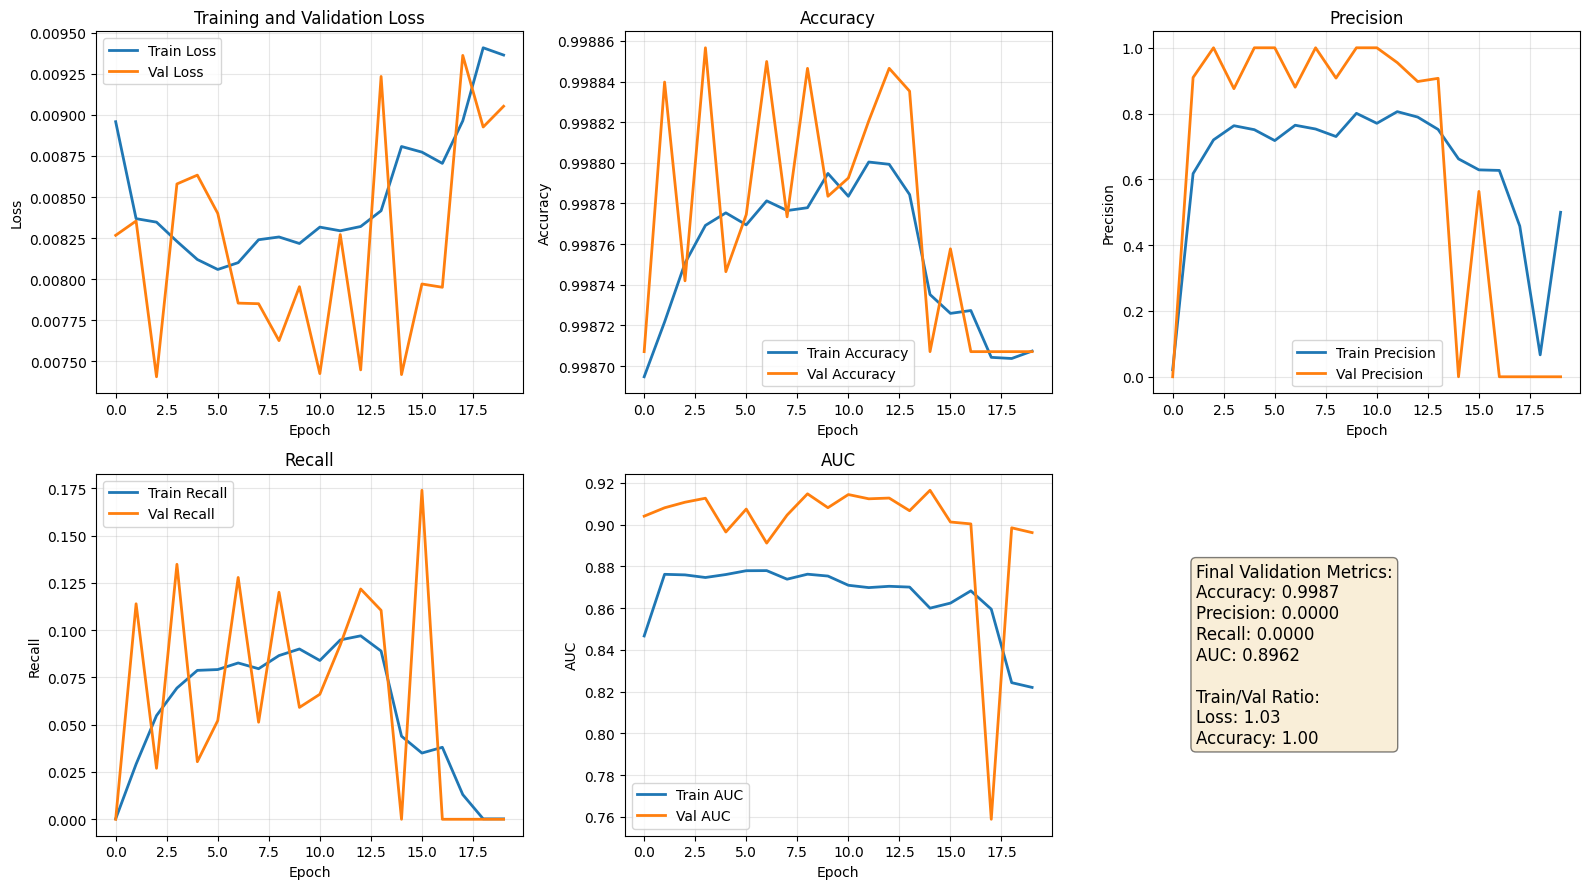

In [ ]:
plot_training_results(train_losses, val_losses, train_metrics, val_metrics)

Testing: 100%|██████████| 29782/29782 [01:18<00:00, 377.19it/s]



TEST SET RESULTS:
Accuracy:  0.9987
Precision: 0.0000
Recall:    0.0000
AUC:       0.8919
F1-Score:  0.0000


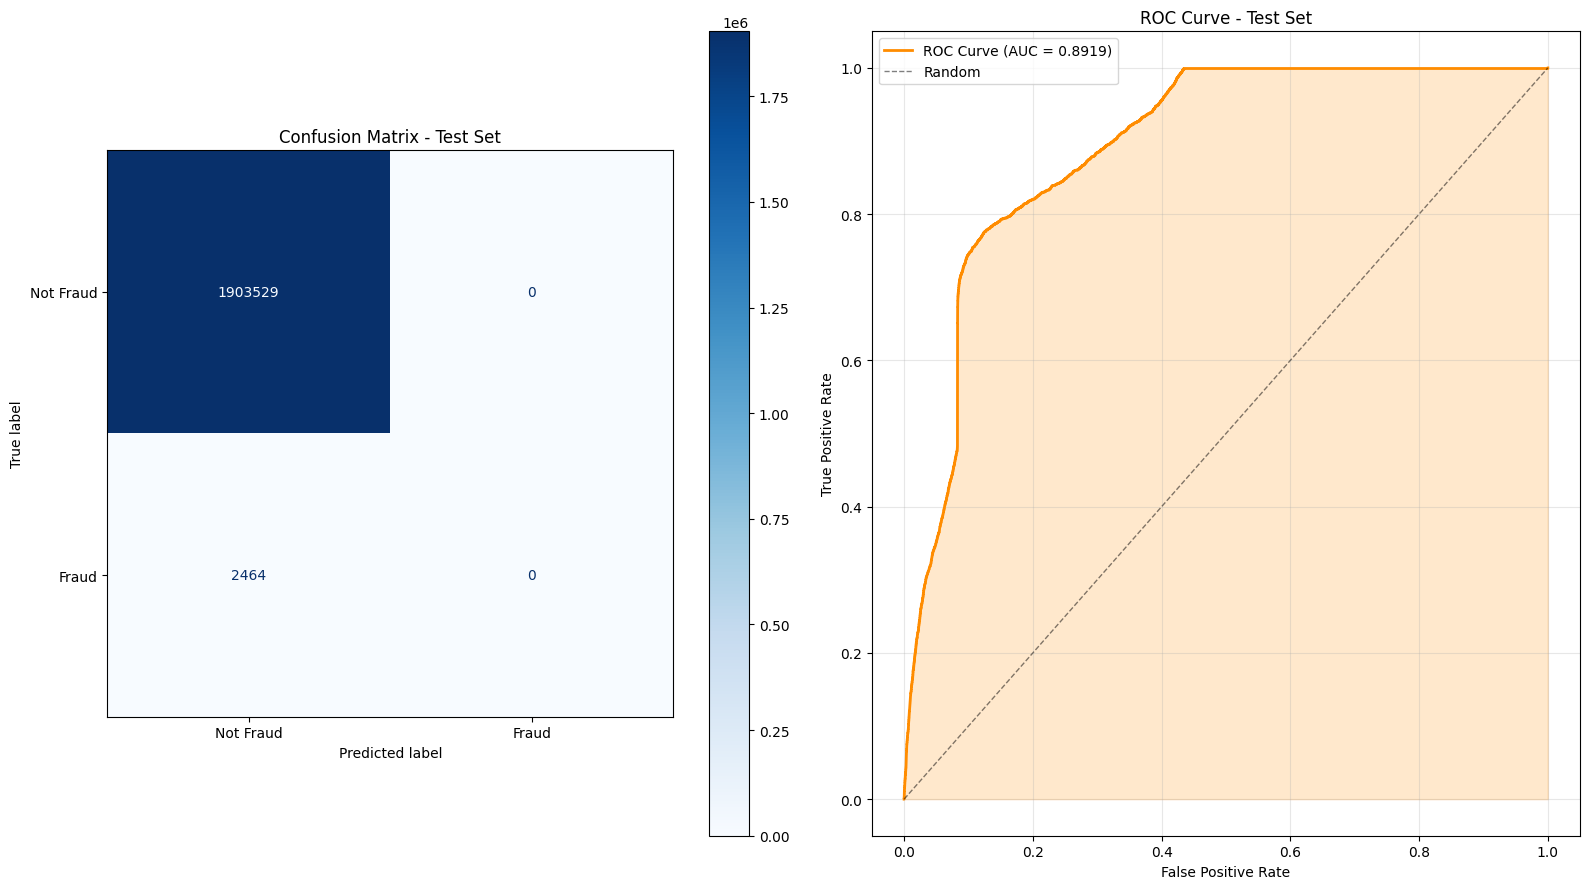

In [ ]:
test_accuracy, test_precision, test_recall, test_auc = test_model(model, test_loader)

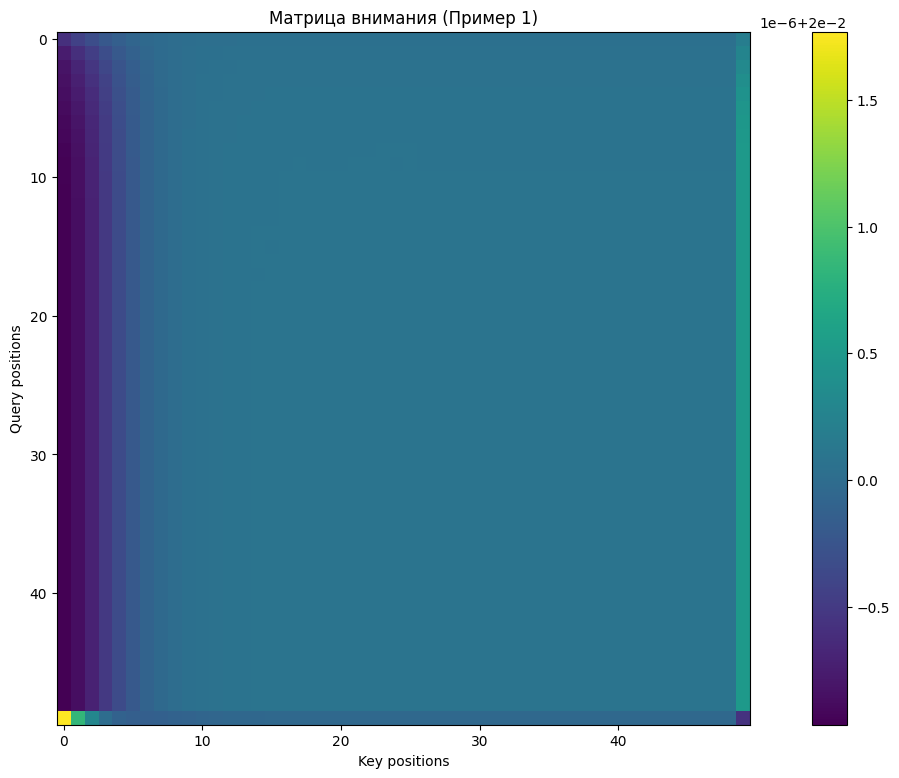

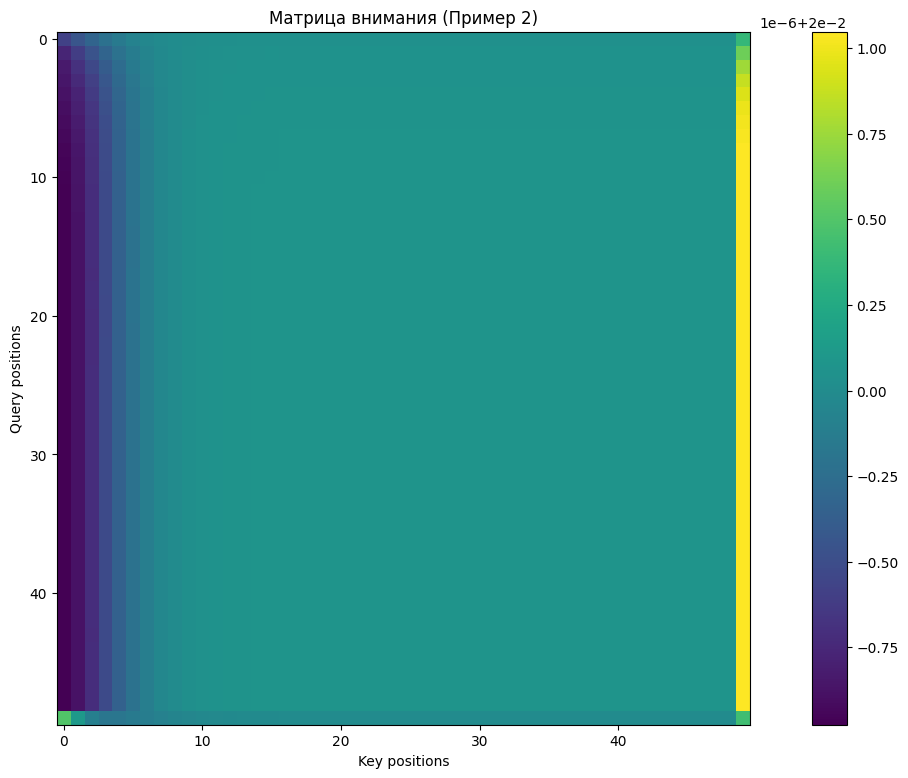

In [ ]:
def analyze_attention(model, data_loader, num_samples=10):
    model.eval()
    attention_samples = []

    with torch.no_grad():
        for batch_idx, (batch_X, batch_y) in enumerate(data_loader):
            if batch_idx >= num_samples:
                break

            outputs, _ = model(batch_X, return_attention=True)

            attention_weights = model.attention_weights[0]

            fig, ax = plt.subplots(figsize=(16, 9))
            im = ax.imshow(attention_weights.numpy(), cmap='viridis')
            ax.set_title(f'Матрица внимания (Пример {batch_idx+1})')
            ax.set_xlabel('Key positions')
            ax.set_ylabel('Query positions')
            plt.colorbar(im, ax=ax)
            plt.show()

            attention_samples.append(attention_weights.numpy())

    return attention_samples

try:
    attention_samples = analyze_attention(model, test_loader, num_samples=2)
except Exception as e:
    print(f"Ошибка при анализе внимания: {e}")

Тут явно видим, что модель просто говорит постоянно не фрод и из-за неадекватного дисбаланса зачастую права. Попробуем ее на обрезанном датасете!

## LSTM на обрезанном датасете

In [219]:
import numpy as np

In [220]:
df_balanced['amount_log'] = np.log1p(df_balanced['amount'])
df_sorted = df_balanced.sort_values(['nameOrig', 'step'])

type_dummies = pd.get_dummies(df_sorted['type'], dtype=np.float32)

features = np.hstack([type_dummies.values, df_sorted[['amount_log']].values])

user_groups = df_sorted.groupby('nameOrig').indices
sequences = {user: features[idx] for user, idx in user_groups.items()}
sequences = pd.Series(sequences)

labels = df_sorted.groupby('nameOrig')['isFraud'].max().loc[sequences.index].values

print(f"Пользователей: {len(sequences)}")
print(f"Фродовых пользователей: {labels.sum()} ({labels.mean()*100:.2f}%)")

Пользователей: 164256
Фродовых пользователей: 8213 (5.00%)


In [221]:
max_len = 50

def pad_sequence(seq, max_length):
    if len(seq) > max_length:
        return seq[-max_length:]
    else:
        return np.pad(seq, ((max_length - len(seq), 0), (0, 0)), mode='constant')

X_padded = np.array([pad_sequence(seq, max_len) for seq in tqdm(sequences)])
y = labels

print(f"Форма данных: {X_padded.shape}")
print(f"Форма меток: {y.shape}")

100%|██████████| 164256/164256 [00:02<00:00, 71023.32it/s]


Форма данных: (164256, 50, 6)
Форма меток: (164256,)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.3, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (91983, 50, 6), (91983,)
Test: (49277, 50, 6), (49277,)


In [223]:
train_loader, val_loader, test_loader = prepare_data_for_pytorch(
    X_train, X_val, X_test, y_train, y_val, y_test
)

Размер батча: 64
Количество батчей в train: 1438
Количество батчей в val: 360
Количество батчей в test: 770


In [224]:
model = AttentionLSTM(
    input_size=6,
    hidden_size=256,
    output_size=1,
    num_layers=2,
    attention_heads=8
).to(device)

In [225]:
num_epochs = 20  
learning_rate = 0.001
test_every = 5

train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics, epoch_test_metrics = train_model_with_testing(
    model, 
    train_loader, 
    val_loader,
    test_loader,
    num_epochs=num_epochs, 
    learning_rate=learning_rate,
    test_every=test_every
)

Using class weights: negative=1.00, positive=1.00
BCEWithLogitsLoss pos_weight: 1.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 354.79it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:02<00:00, 356.05it/s]


Test Loss: 0.1416, Acc: 0.9501, Prec: 1.0000, Rec: 0.0020, AUC: 0.8890

Epoch 1/20:
  Train Loss: 0.1522, Acc: 0.9494, Prec: 0.0462, Rec: 0.0007, AUC: 0.8583
  Val Loss: 0.1410, Acc: 0.9500, Prec: 1.0000, Rec: 0.0009, AUC: 0.8866
--------------------------------------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 356.87it/s]


Epoch 2/20:
  Train Loss: 0.1393, Acc: 0.9512, Prec: 0.9141, Rec: 0.0254, AUC: 0.8897
  Val Loss: 0.1431, Acc: 0.9500, Prec: 1.0000, Rec: 0.0009, AUC: 0.8940
--------------------------------------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 356.87it/s]


Epoch 3/20:
  Train Loss: 0.1264, Acc: 0.9561, Prec: 0.8285, Rec: 0.1544, AUC: 0.9064
  Val Loss: 0.1214, Acc: 0.9583, Prec: 0.7885, Rec: 0.2270, AUC: 0.9168
--------------------------------------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 367.46it/s]


Epoch 4/20:
  Train Loss: 0.1218, Acc: 0.9573, Prec: 0.8218, Rec: 0.1855, AUC: 0.9112
  Val Loss: 0.1184, Acc: 0.9584, Prec: 0.9709, Rec: 0.1739, AUC: 0.9181
--------------------------------------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 360.85it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 5:


Testing on Test Set: 100%|██████████| 770/770 [00:02<00:00, 355.83it/s]


Test Loss: 0.1177, Acc: 0.9585, Prec: 0.9605, Rec: 0.1778, AUC: 0.9184

Epoch 5/20:
  Train Loss: 0.1203, Acc: 0.9578, Prec: 0.8456, Rec: 0.1918, AUC: 0.9140
  Val Loss: 0.1187, Acc: 0.9579, Prec: 0.9641, Rec: 0.1635, AUC: 0.9163
--------------------------------------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 360.40it/s]


Epoch 6/20:
  Train Loss: 0.1196, Acc: 0.9579, Prec: 0.8224, Rec: 0.2013, AUC: 0.9143
  Val Loss: 0.1271, Acc: 0.9548, Prec: 0.9365, Rec: 0.1026, AUC: 0.9092
--------------------------------------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 359.29it/s]


Epoch 7/20:
  Train Loss: 0.1190, Acc: 0.9584, Prec: 0.8125, Rec: 0.2177, AUC: 0.9163
  Val Loss: 0.1187, Acc: 0.9593, Prec: 0.8152, Rec: 0.2417, AUC: 0.9153
--------------------------------------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 358.46it/s]


Epoch 8/20:
  Train Loss: 0.1186, Acc: 0.9580, Prec: 0.8035, Rec: 0.2116, AUC: 0.9161
  Val Loss: 0.1167, Acc: 0.9592, Prec: 0.8397, Rec: 0.2278, AUC: 0.9183
--------------------------------------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 355.32it/s]


Epoch 9/20:
  Train Loss: 0.1183, Acc: 0.9585, Prec: 0.8123, Rec: 0.2220, AUC: 0.9170
  Val Loss: 0.1176, Acc: 0.9588, Prec: 0.8285, Rec: 0.2226, AUC: 0.9173
--------------------------------------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 346.88it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 10:


Testing on Test Set: 100%|██████████| 770/770 [00:02<00:00, 351.63it/s]


Test Loss: 0.1155, Acc: 0.9603, Prec: 0.8447, Rec: 0.2516, AUC: 0.9199

Epoch 10/20:
  Train Loss: 0.1183, Acc: 0.9584, Prec: 0.8109, Rec: 0.2200, AUC: 0.9163
  Val Loss: 0.1171, Acc: 0.9589, Prec: 0.8160, Rec: 0.2313, AUC: 0.9182
--------------------------------------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 352.67it/s]


Epoch 11/20:
  Train Loss: 0.1182, Acc: 0.9584, Prec: 0.7981, Rec: 0.2235, AUC: 0.9170
  Val Loss: 0.1187, Acc: 0.9579, Prec: 0.8521, Rec: 0.1904, AUC: 0.9173
--------------------------------------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 359.36it/s]


Epoch 12/20:
  Train Loss: 0.1185, Acc: 0.9586, Prec: 0.8079, Rec: 0.2259, AUC: 0.9166
  Val Loss: 0.1184, Acc: 0.9581, Prec: 0.8370, Rec: 0.2009, AUC: 0.9174
--------------------------------------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 344.28it/s]


Epoch 13/20:
  Train Loss: 0.1184, Acc: 0.9585, Prec: 0.7907, Rec: 0.2301, AUC: 0.9166
  Val Loss: 0.1176, Acc: 0.9583, Prec: 0.8243, Rec: 0.2122, AUC: 0.9176
--------------------------------------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 342.12it/s]


Epoch 14/20:
  Train Loss: 0.1179, Acc: 0.9587, Prec: 0.8040, Rec: 0.2301, AUC: 0.9173
  Val Loss: 0.1170, Acc: 0.9591, Prec: 0.8472, Rec: 0.2217, AUC: 0.9179
--------------------------------------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 357.14it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 15:


Testing on Test Set: 100%|██████████| 770/770 [00:02<00:00, 356.49it/s]


Test Loss: 0.1164, Acc: 0.9602, Prec: 0.8344, Rec: 0.2557, AUC: 0.9199

Epoch 15/20:
  Train Loss: 0.1183, Acc: 0.9587, Prec: 0.8065, Rec: 0.2283, AUC: 0.9165
  Val Loss: 0.1179, Acc: 0.9590, Prec: 0.8127, Rec: 0.2339, AUC: 0.9182
--------------------------------------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 358.33it/s]


Epoch 16/20:
  Train Loss: 0.1184, Acc: 0.9586, Prec: 0.8020, Rec: 0.2281, AUC: 0.9162
  Val Loss: 0.1179, Acc: 0.9590, Prec: 0.7717, Rec: 0.2557, AUC: 0.9165
--------------------------------------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 360/360 [00:01<00:00, 334.96it/s]


Epoch 17/20:
  Train Loss: 0.1187, Acc: 0.9585, Prec: 0.7820, Rec: 0.2348, AUC: 0.9160
  Val Loss: 0.1169, Acc: 0.9593, Prec: 0.8098, Rec: 0.2443, AUC: 0.9181
--------------------------------------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 364.33it/s]


Epoch 18/20:
  Train Loss: 0.1174, Acc: 0.9589, Prec: 0.7972, Rec: 0.2377, AUC: 0.9174
  Val Loss: 0.1176, Acc: 0.9584, Prec: 0.8277, Rec: 0.2130, AUC: 0.9180
--------------------------------------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 366.66it/s]


Epoch 19/20:
  Train Loss: 0.1178, Acc: 0.9588, Prec: 0.8039, Rec: 0.2335, AUC: 0.9173
  Val Loss: 0.1169, Acc: 0.9590, Prec: 0.8090, Rec: 0.2357, AUC: 0.9180
--------------------------------------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 362.95it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 20:


Testing on Test Set: 100%|██████████| 770/770 [00:02<00:00, 374.61it/s]

Test Loss: 0.1153, Acc: 0.9607, Prec: 0.8243, Rec: 0.2723, AUC: 0.9188

Epoch 20/20:
  Train Loss: 0.1174, Acc: 0.9590, Prec: 0.8124, Rec: 0.2335, AUC: 0.9179
  Val Loss: 0.1174, Acc: 0.9590, Prec: 0.7905, Rec: 0.2461, AUC: 0.9169
--------------------------------------------------------------------------------


In [226]:
import matplotlib.pyplot as plt

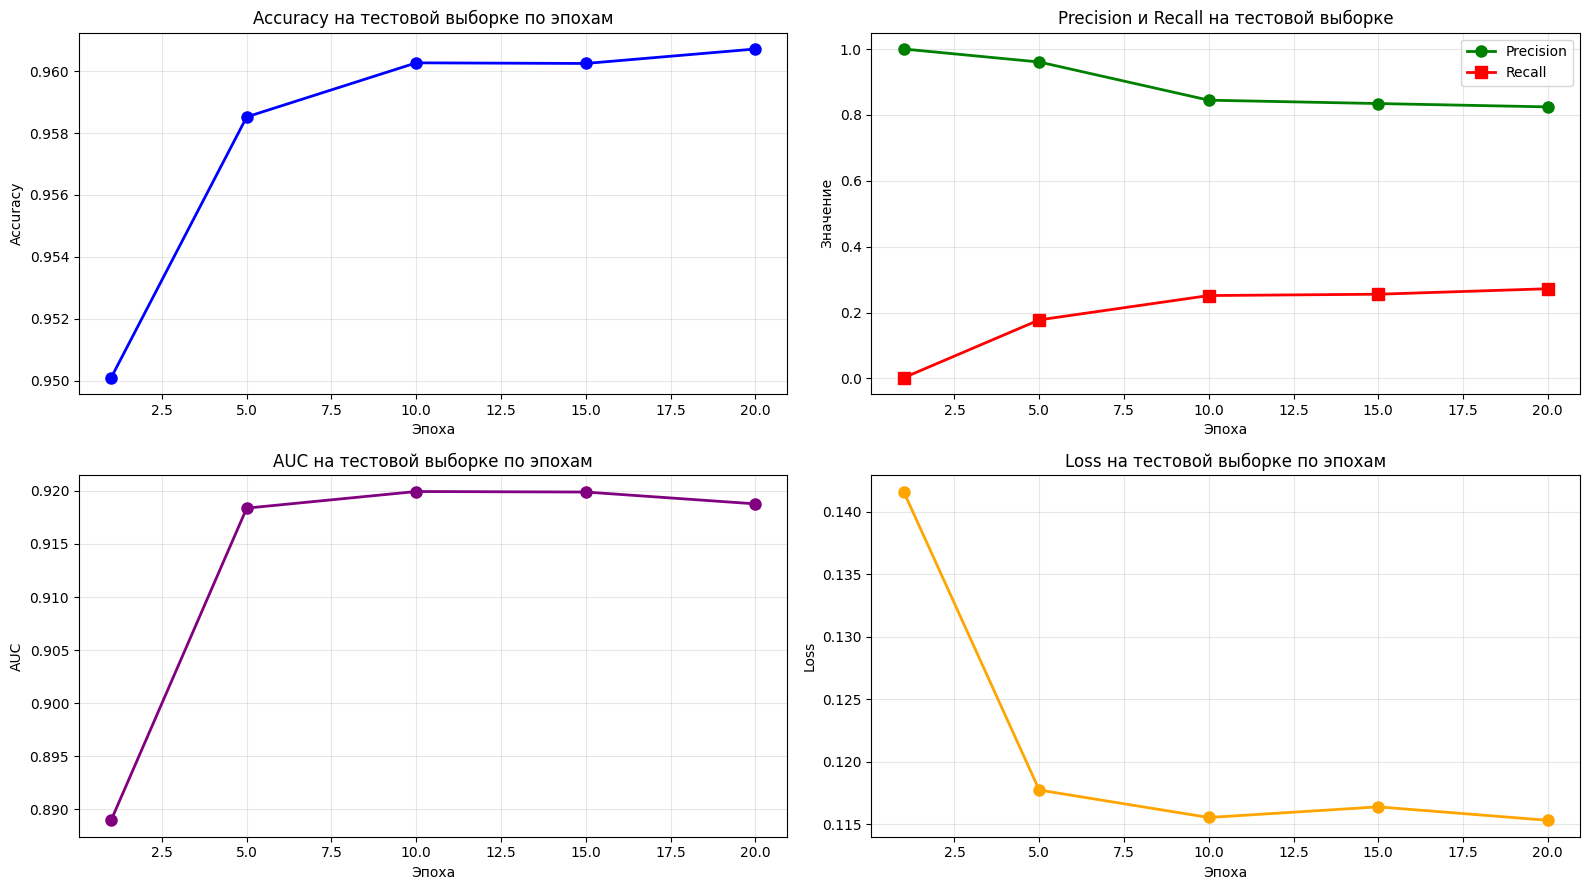

1        0.1416     0.9501     1.0000     0.0020     0.8890    
5        0.1177     0.9585     0.9605     0.1778     0.9184    
10       0.1155     0.9603     0.8447     0.2516     0.9199    
15       0.1164     0.9602     0.8344     0.2557     0.9199    
20       0.1153     0.9607     0.8243     0.2723     0.9188    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.9199 на эпохе 10
Лучшая Accuracy: 0.9607 на эпохе 20


In [227]:
best_auc_epoch, best_acc_epoch = plot_test_metrics_by_epoch(epoch_test_metrics)

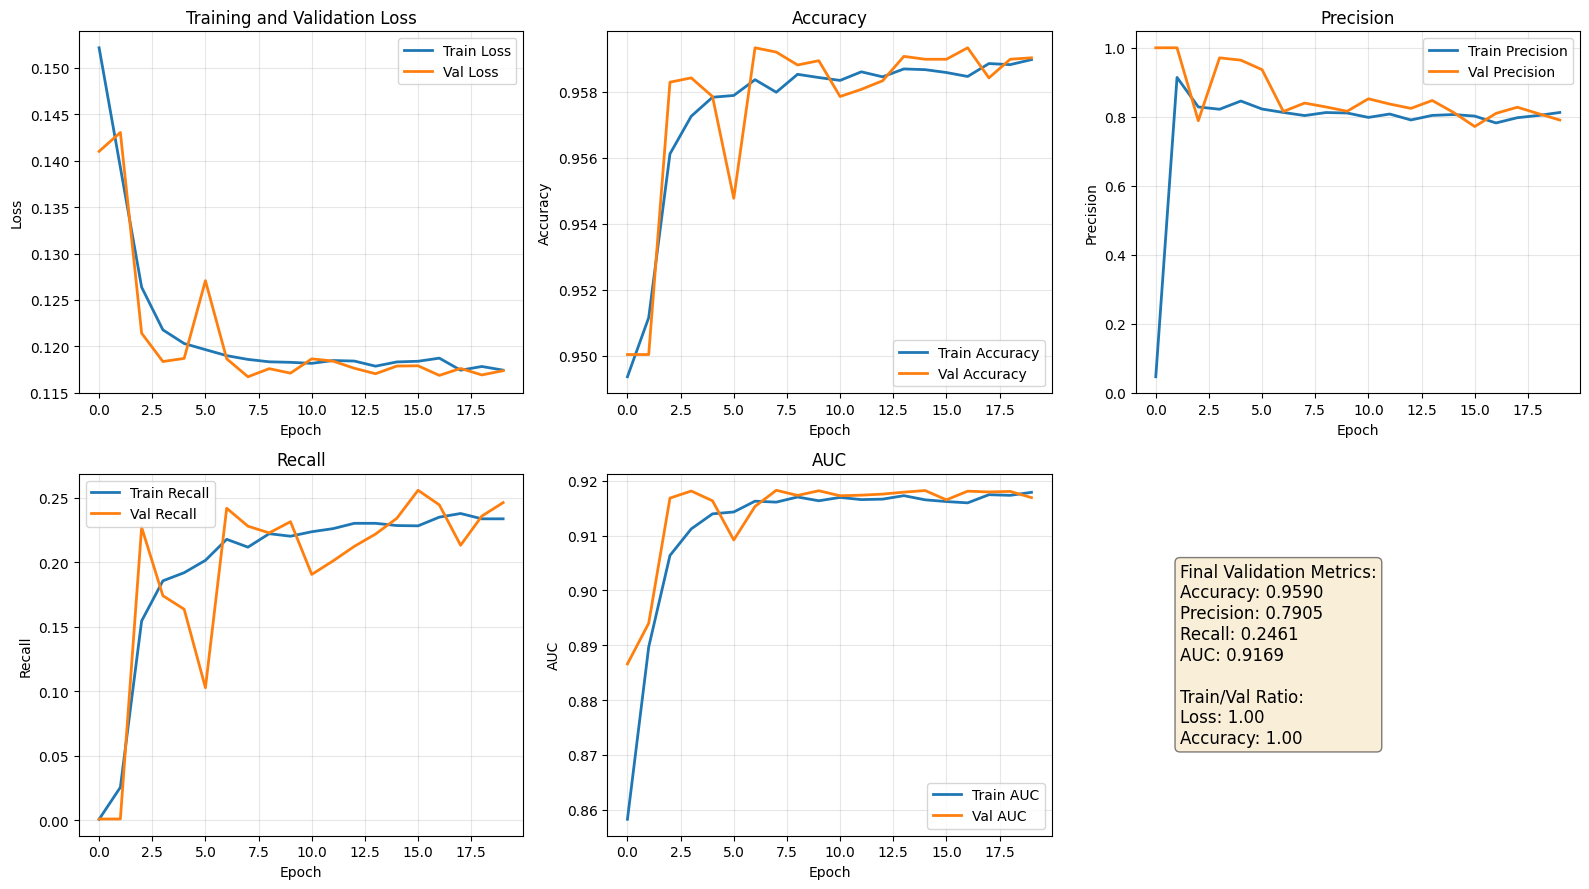

In [228]:
plot_training_results(train_losses, val_losses, train_metrics, val_metrics)

Testing: 100%|██████████| 770/770 [00:01<00:00, 387.30it/s]



TEST SET RESULTS:
Accuracy:  0.9607
Precision: 0.8243
Recall:    0.2723
AUC:       0.9188
F1-Score:  0.4094


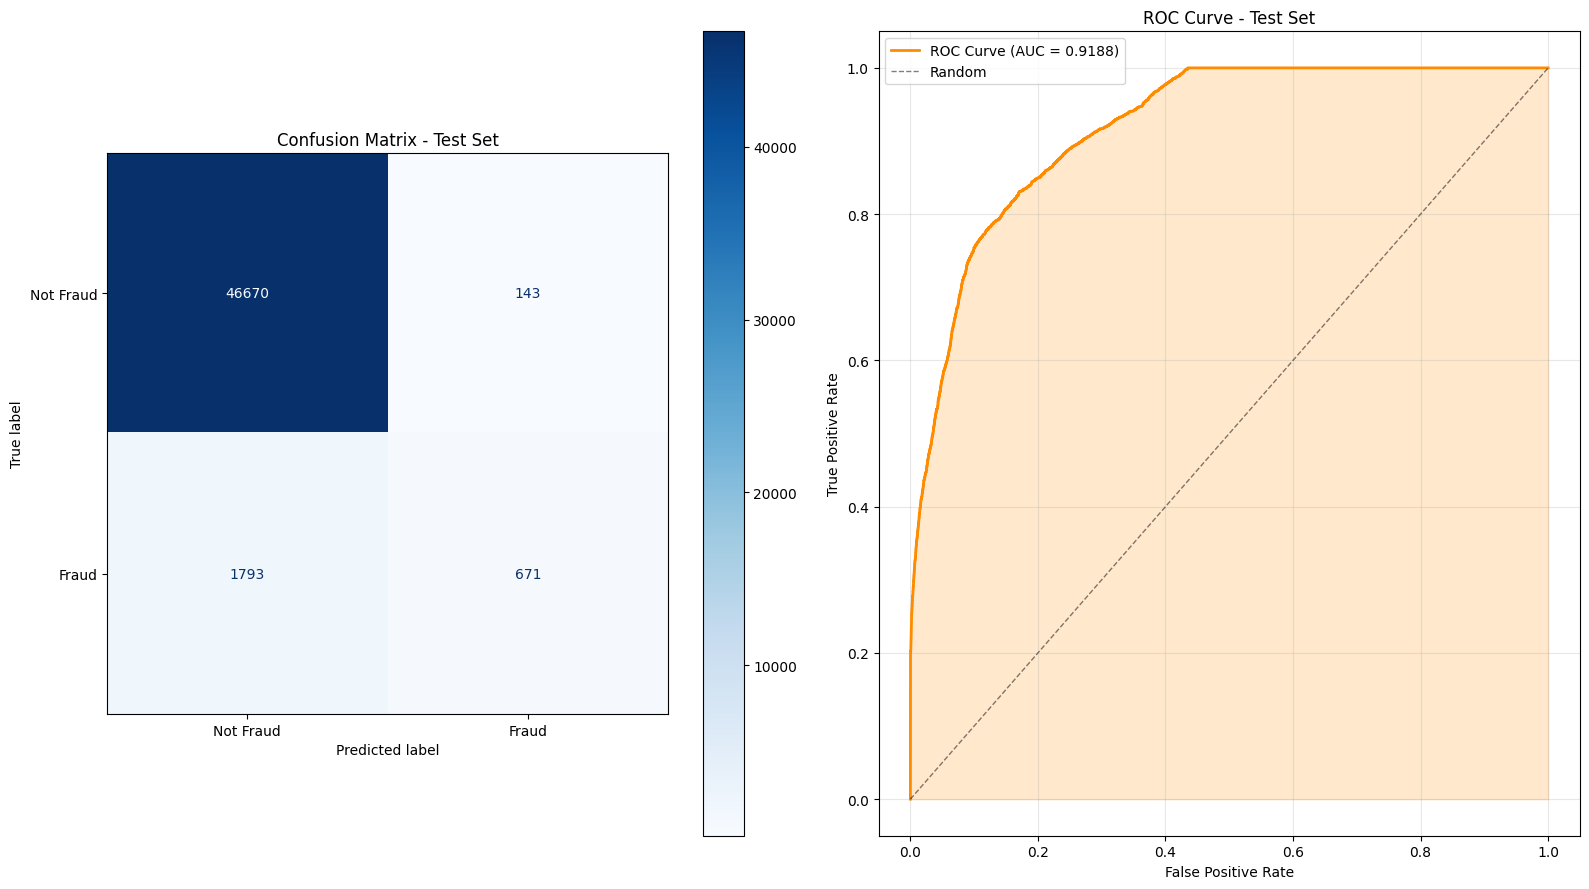

In [229]:
test_accuracy, test_precision, test_recall, test_auc = test_model(model, test_loader)

Вывод: обрезав датасет получилось увеличить уровень Recall. Моделька теперь начинает все же обращать внимание на фрод. Модель все еще допускает много ошибок: признает мошеннические операции правомерными.

## Mambo Italiano

In [230]:
df['amount_log'] = np.log1p(df['amount'])
df_sorted = df.sort_values(['nameOrig', 'step'])

type_dummies = pd.get_dummies(df_sorted['type'], dtype=np.float32)

features = np.hstack([type_dummies.values, df_sorted[['amount_log']].values])

user_groups = df_sorted.groupby('nameOrig').indices
sequences = {user: features[idx] for user, idx in user_groups.items()}
sequences = pd.Series(sequences)

labels = df_sorted.groupby('nameOrig')['isFraud'].max().loc[sequences.index].values

print(f"Пользователей: {len(sequences)}")
print(f"Фродовых пользователей: {labels.sum()} ({labels.mean()*100:.2f}%)")

Пользователей: 6353307
Фродовых пользователей: 8213 (0.13%)


In [231]:
max_len = 50

def pad_sequence(seq, max_length):
    if len(seq) > max_length:
        return seq[-max_length:]
    else:
        return np.pad(seq, ((max_length - len(seq), 0), (0, 0)), mode='constant')

X_padded = np.array([pad_sequence(seq, max_len) for seq in tqdm(sequences)])
y = labels

print(f"Форма данных: {X_padded.shape}")
print(f"Форма меток: {y.shape}")

100%|██████████| 6353307/6353307 [01:25<00:00, 74514.84it/s]


Форма данных: (6353307, 50, 6)
Форма меток: (6353307,)


In [232]:
# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
print(f"Доступно GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Название GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Используемое устройство: cuda
Доступно GPU: True
Название GPU: NVIDIA GeForce RTX 4070 SUPER
Память GPU: 12.88 GB


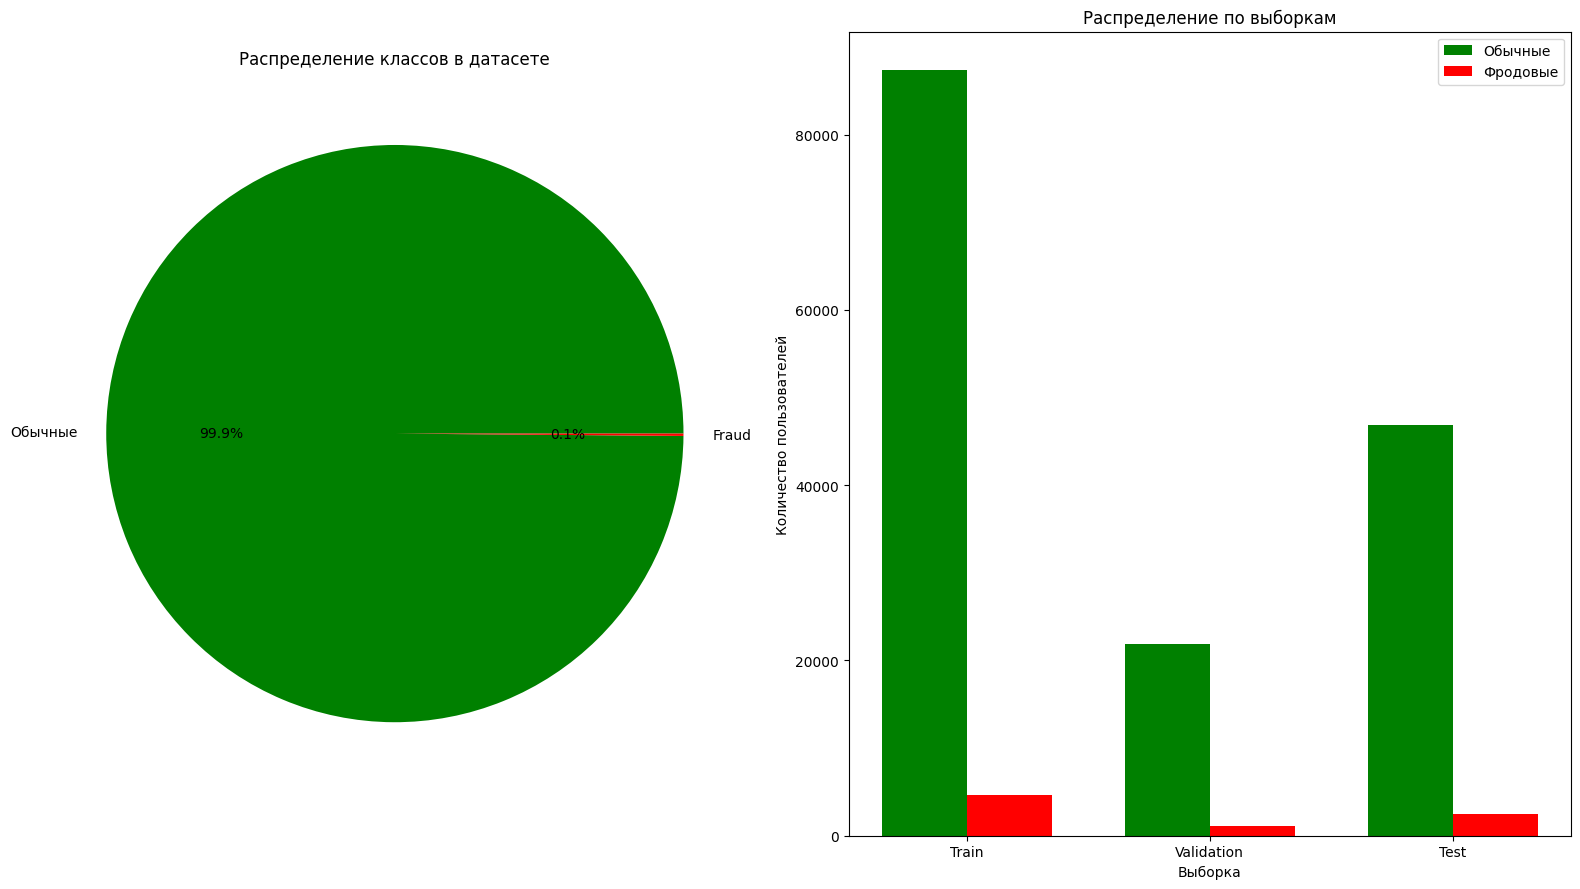

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fraud_count = sum(y)
non_fraud_count = len(y) - fraud_count
ax1.pie([non_fraud_count, fraud_count],
        labels=['Обычные', 'Fraud'],
        autopct='%1.1f%%',
        colors=['green', 'red'])
ax1.set_title('Распределение классов в датасете')

splits = ['Train', 'Validation', 'Test']
fraud_counts = [sum(y_train), sum(y_val), sum(y_test)]
total_counts = [len(y_train), len(y_val), len(y_test)]
non_fraud_counts = [total - fraud for total, fraud in zip(total_counts, fraud_counts)]

x = np.arange(len(splits))
width = 0.35

ax2.bar(x - width/2, non_fraud_counts, width, label='Обычные', color='green')
ax2.bar(x + width/2, fraud_counts, width, label='Фродовые', color='red')
ax2.set_xlabel('Выборка')
ax2.set_ylabel('Количество пользователей')
ax2.set_title('Распределение по выборкам')
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.legend()

plt.tight_layout()
plt.show()

In [234]:
def prepare_data_for_pytorch(X_train, X_val, X_test, y_train, y_val, y_test):
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)

    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Размер батча: {batch_size}")
    print(f"Количество батчей в train: {len(train_loader)}")
    print(f"Количество батчей в val: {len(val_loader)}")
    print(f"Количество батчей в test: {len(test_loader)}")

    return train_loader, val_loader, test_loader

In [235]:
def calculate_metrics(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except:
        auc = 0.0

    return accuracy, precision, recall, auc

In [236]:
train_loader, val_loader, test_loader = prepare_data_for_pytorch(
    X_train, X_val, X_test, y_train, y_val, y_test
)

Размер батча: 64
Количество батчей в train: 1438
Количество батчей в val: 360
Количество батчей в test: 770


In [237]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps - 1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan: Callable[[Tensor, Tensor], Tensor] = PScan.apply

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        return self.out_proj(x + B + C)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super(Mamba, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])

    def forward(self, seq):
        for mamba in self.layers:
            seq = mamba(seq)
        return seq

class MambaClassifier(nn.Module):
    def __init__(self, num_layers, d_input, d_model, output_dim=1):
        super().__init__()
        self.backbone = Mamba(num_layers, d_input, d_model)
        self.classifier = nn.Linear(d_input, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x_last = x[:, -1, :]
        logits = self.classifier(x_last)
        return logits, None

In [238]:
model = MambaClassifier(
    num_layers=4,
    d_input=X_train.shape[2],
    d_model=64
).to(device)


In [239]:
class_weights_grid = (
    [1., 1.],
    [1., 5.],
    [1., 10.],
    [1., 20.]
)
num_epochs = 20  
learning_rate = 0.001
test_every = 5


We are talking about weights [1.0, 1.0]

Using class weights: negative=1.00, positive=1.00
BCEWithLogitsLoss pos_weight: 1.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 424.75it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 439.43it/s]


Test Loss: 0.1453, Acc: 0.9499, Prec: 0.0000, Rec: 0.0000, AUC: 0.8877

Epoch 1/20:
  Train Loss: 0.1471, Acc: 0.9493, Prec: 0.3724, Rec: 0.0194, AUC: 0.8786
  Val Loss: 0.1447, Acc: 0.9500, Prec: 0.0000, Rec: 0.0000, AUC: 0.8858
--------------------------------------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 774.61it/s]


Epoch 2/20:
  Train Loss: 0.1447, Acc: 0.9499, Prec: 0.4648, Rec: 0.0072, AUC: 0.8830
  Val Loss: 0.1441, Acc: 0.9500, Prec: 0.5000, Rec: 0.0304, AUC: 0.8854
--------------------------------------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 768.51it/s]


Epoch 3/20:
  Train Loss: 0.1440, Acc: 0.9498, Prec: 0.4167, Rec: 0.0098, AUC: 0.8835
  Val Loss: 0.1444, Acc: 0.9500, Prec: 0.0000, Rec: 0.0000, AUC: 0.8853
--------------------------------------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 743.10it/s]


Epoch 4/20:
  Train Loss: 0.1440, Acc: 0.9499, Prec: 0.4471, Rec: 0.0083, AUC: 0.8843
  Val Loss: 0.1428, Acc: 0.9501, Prec: 0.5231, Rec: 0.0296, AUC: 0.8846
--------------------------------------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 702.21it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 5:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 755.74it/s]


Test Loss: 0.1433, Acc: 0.9508, Prec: 0.6133, Rec: 0.0450, AUC: 0.8875

Epoch 5/20:
  Train Loss: 0.1440, Acc: 0.9498, Prec: 0.4271, Rec: 0.0089, AUC: 0.8836
  Val Loss: 0.1430, Acc: 0.9501, Prec: 0.5114, Rec: 0.0391, AUC: 0.8848
--------------------------------------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 788.26it/s]


Epoch 6/20:
  Train Loss: 0.1441, Acc: 0.9499, Prec: 0.4545, Rec: 0.0087, AUC: 0.8834
  Val Loss: 0.1441, Acc: 0.9503, Prec: 0.5294, Rec: 0.0548, AUC: 0.8848
--------------------------------------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 788.52it/s]


Epoch 7/20:
  Train Loss: 0.1441, Acc: 0.9502, Prec: 0.5678, Rec: 0.0146, AUC: 0.8834
  Val Loss: 0.1428, Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, AUC: 0.8850
--------------------------------------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 765.73it/s]


Epoch 8/20:
  Train Loss: 0.1440, Acc: 0.9499, Prec: 0.4557, Rec: 0.0078, AUC: 0.8839
  Val Loss: 0.1439, Acc: 0.9500, Prec: 0.5000, Rec: 0.0252, AUC: 0.8843
--------------------------------------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 720.51it/s]


Epoch 9/20:
  Train Loss: 0.1441, Acc: 0.9500, Prec: 0.4876, Rec: 0.0128, AUC: 0.8834
  Val Loss: 0.1432, Acc: 0.9499, Prec: 0.0000, Rec: 0.0000, AUC: 0.8853
--------------------------------------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 753.88it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 10:


Testing on Test Set: 100%|██████████| 770/770 [00:00<00:00, 801.41it/s]


Test Loss: 0.1450, Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, AUC: 0.8877

Epoch 10/20:
  Train Loss: 0.1440, Acc: 0.9500, Prec: 0.5000, Rec: 0.0111, AUC: 0.8842
  Val Loss: 0.1448, Acc: 0.9499, Prec: 0.0000, Rec: 0.0000, AUC: 0.8853
--------------------------------------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 771.90it/s]


Epoch 11/20:
  Train Loss: 0.1440, Acc: 0.9500, Prec: 0.5052, Rec: 0.0107, AUC: 0.8845
  Val Loss: 0.1436, Acc: 0.9499, Prec: 0.0000, Rec: 0.0000, AUC: 0.8848
--------------------------------------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 778.42it/s]


Epoch 12/20:
  Train Loss: 0.1439, Acc: 0.9500, Prec: 0.4792, Rec: 0.0100, AUC: 0.8842
  Val Loss: 0.1431, Acc: 0.9500, Prec: 0.5088, Rec: 0.0252, AUC: 0.8838
--------------------------------------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 735.24it/s]


Epoch 13/20:
  Train Loss: 0.1439, Acc: 0.9499, Prec: 0.4685, Rec: 0.0113, AUC: 0.8837
  Val Loss: 0.1430, Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, AUC: 0.8854
--------------------------------------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 715.69it/s]


Epoch 14/20:
  Train Loss: 0.1440, Acc: 0.9499, Prec: 0.4510, Rec: 0.0100, AUC: 0.8852
  Val Loss: 0.1431, Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, AUC: 0.8848
--------------------------------------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 680.94it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 15:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 702.96it/s]


Test Loss: 0.1457, Acc: 0.9501, Prec: 0.5366, Rec: 0.0179, AUC: 0.8877

Epoch 15/20:
  Train Loss: 0.1439, Acc: 0.9500, Prec: 0.5082, Rec: 0.0135, AUC: 0.8845
  Val Loss: 0.1453, Acc: 0.9501, Prec: 0.5349, Rec: 0.0200, AUC: 0.8856
--------------------------------------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 699.77it/s]


Epoch 16/20:
  Train Loss: 0.1441, Acc: 0.9499, Prec: 0.4425, Rec: 0.0109, AUC: 0.8846
  Val Loss: 0.1430, Acc: 0.9499, Prec: 0.0000, Rec: 0.0000, AUC: 0.8851
--------------------------------------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 770.98it/s]


Epoch 17/20:
  Train Loss: 0.1441, Acc: 0.9499, Prec: 0.4479, Rec: 0.0093, AUC: 0.8845
  Val Loss: 0.1444, Acc: 0.9500, Prec: 0.0000, Rec: 0.0000, AUC: 0.8850
--------------------------------------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 717.59it/s]


Epoch 18/20:
  Train Loss: 0.1439, Acc: 0.9498, Prec: 0.4375, Rec: 0.0122, AUC: 0.8841
  Val Loss: 0.1428, Acc: 0.9497, Prec: 0.0000, Rec: 0.0000, AUC: 0.8852
--------------------------------------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 699.68it/s]


Epoch 19/20:
  Train Loss: 0.1438, Acc: 0.9501, Prec: 0.5310, Rec: 0.0130, AUC: 0.8852
  Val Loss: 0.1428, Acc: 0.9497, Prec: 0.0000, Rec: 0.0000, AUC: 0.8850
--------------------------------------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 727.85it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 20:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 722.94it/s]


Test Loss: 0.1434, Acc: 0.9506, Prec: 0.5987, Rec: 0.0369, AUC: 0.8875

Epoch 20/20:
  Train Loss: 0.1439, Acc: 0.9500, Prec: 0.4949, Rec: 0.0107, AUC: 0.8844
  Val Loss: 0.1431, Acc: 0.9501, Prec: 0.5135, Rec: 0.0330, AUC: 0.8848
--------------------------------------------------------------------------------


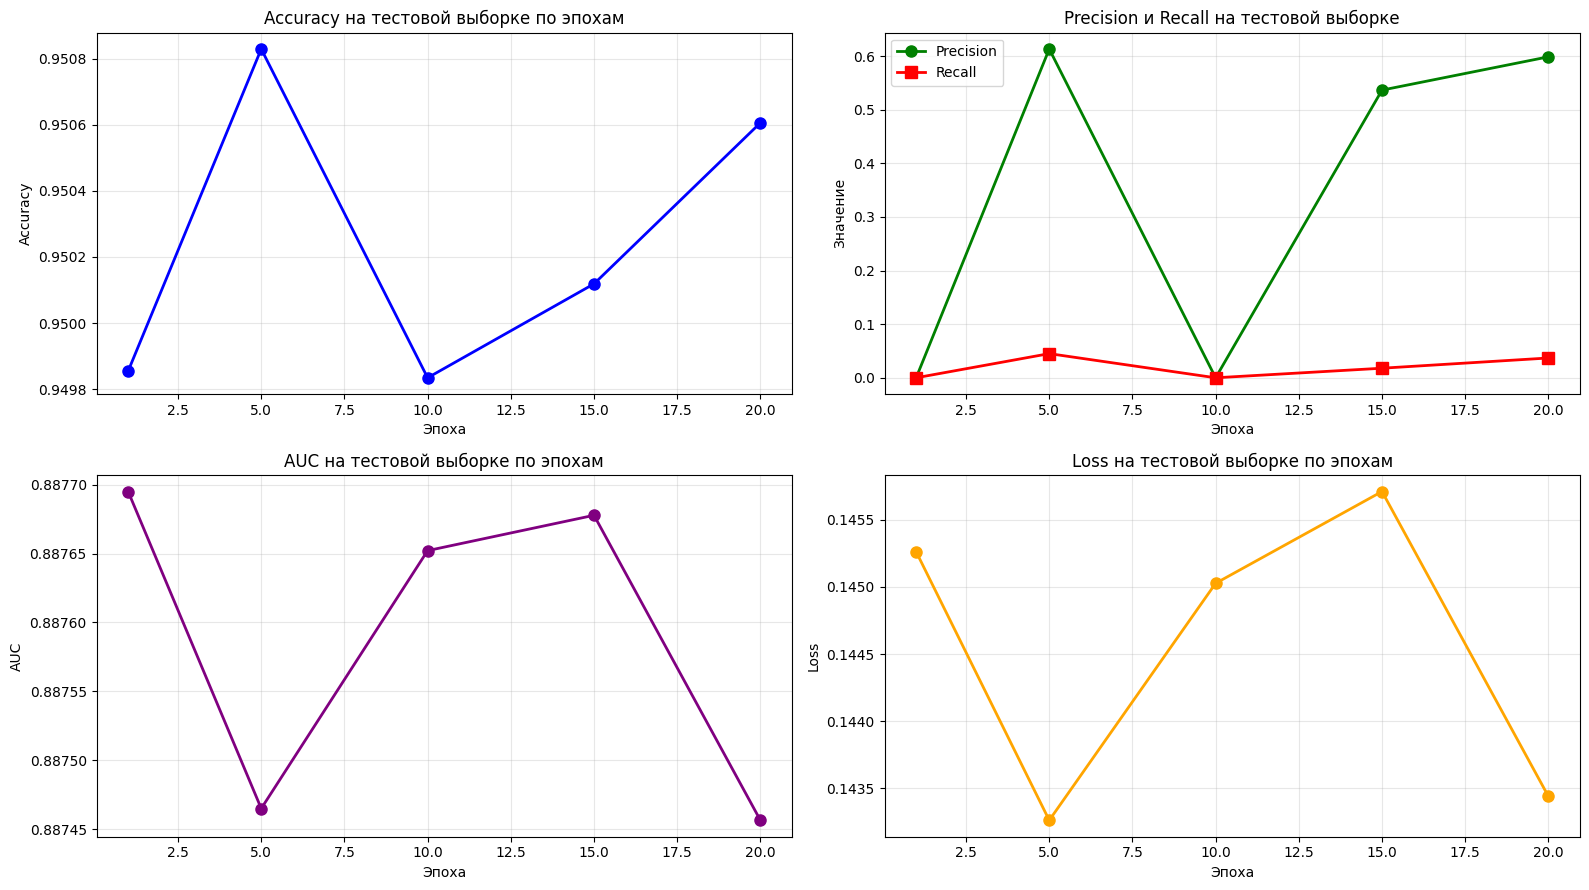

1        0.1453     0.9499     0.0000     0.0000     0.8877    
5        0.1433     0.9508     0.6133     0.0450     0.8875    
10       0.1450     0.9498     0.0000     0.0000     0.8877    
15       0.1457     0.9501     0.5366     0.0179     0.8877    
20       0.1434     0.9506     0.5987     0.0369     0.8875    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.8877 на эпохе 1
Лучшая Accuracy: 0.9508 на эпохе 5


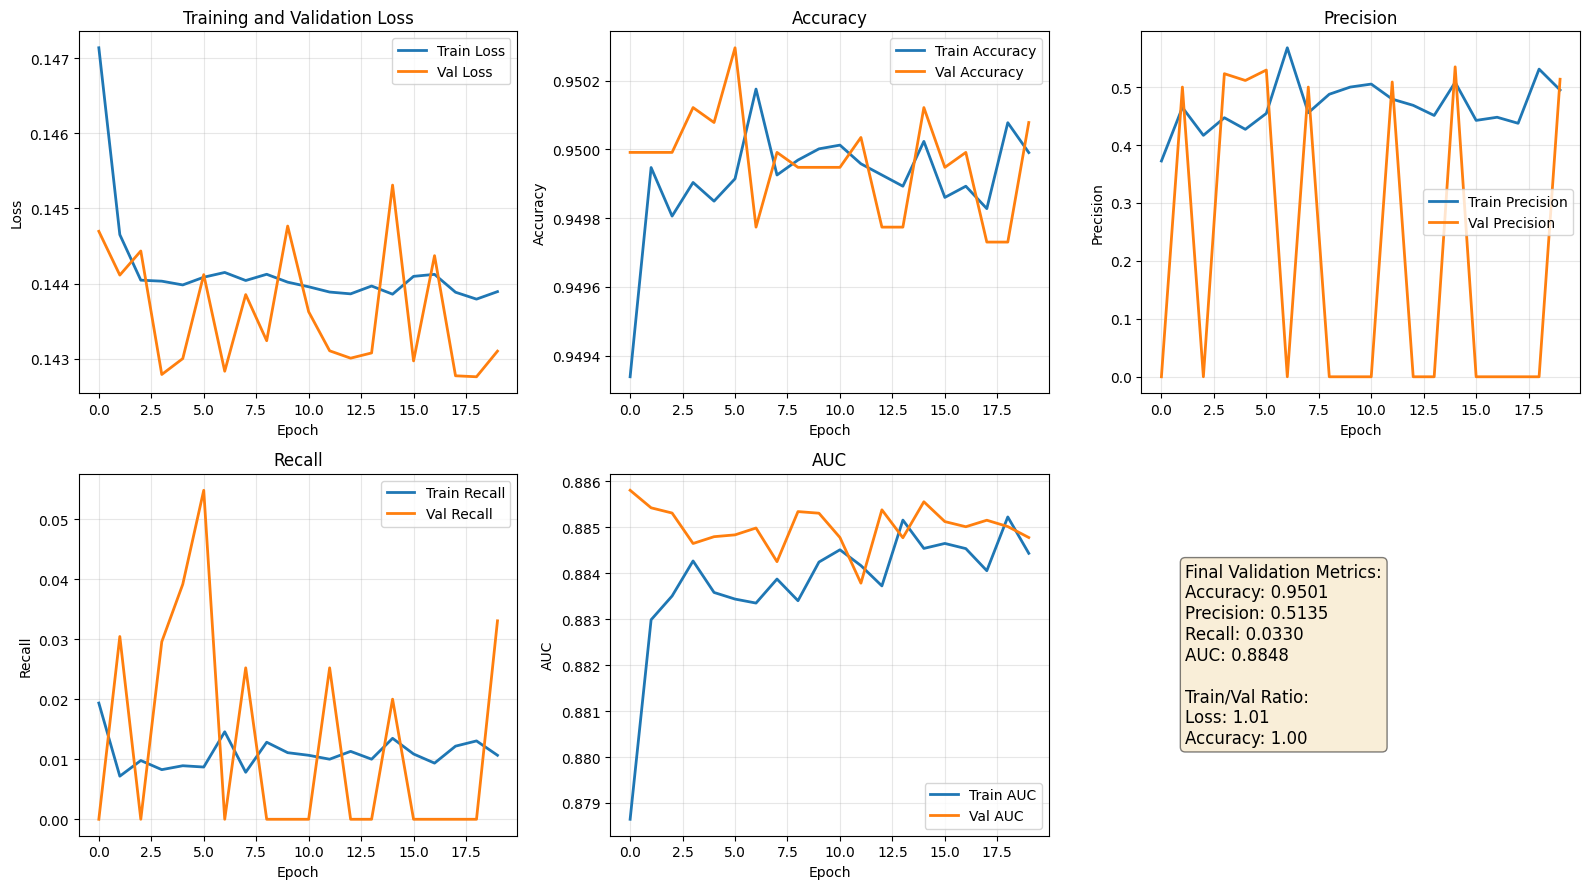

Testing: 100%|██████████| 770/770 [00:00<00:00, 833.74it/s]



TEST SET RESULTS:
Accuracy:  0.9506
Precision: 0.5987
Recall:    0.0369
AUC:       0.8875
F1-Score:  0.0696


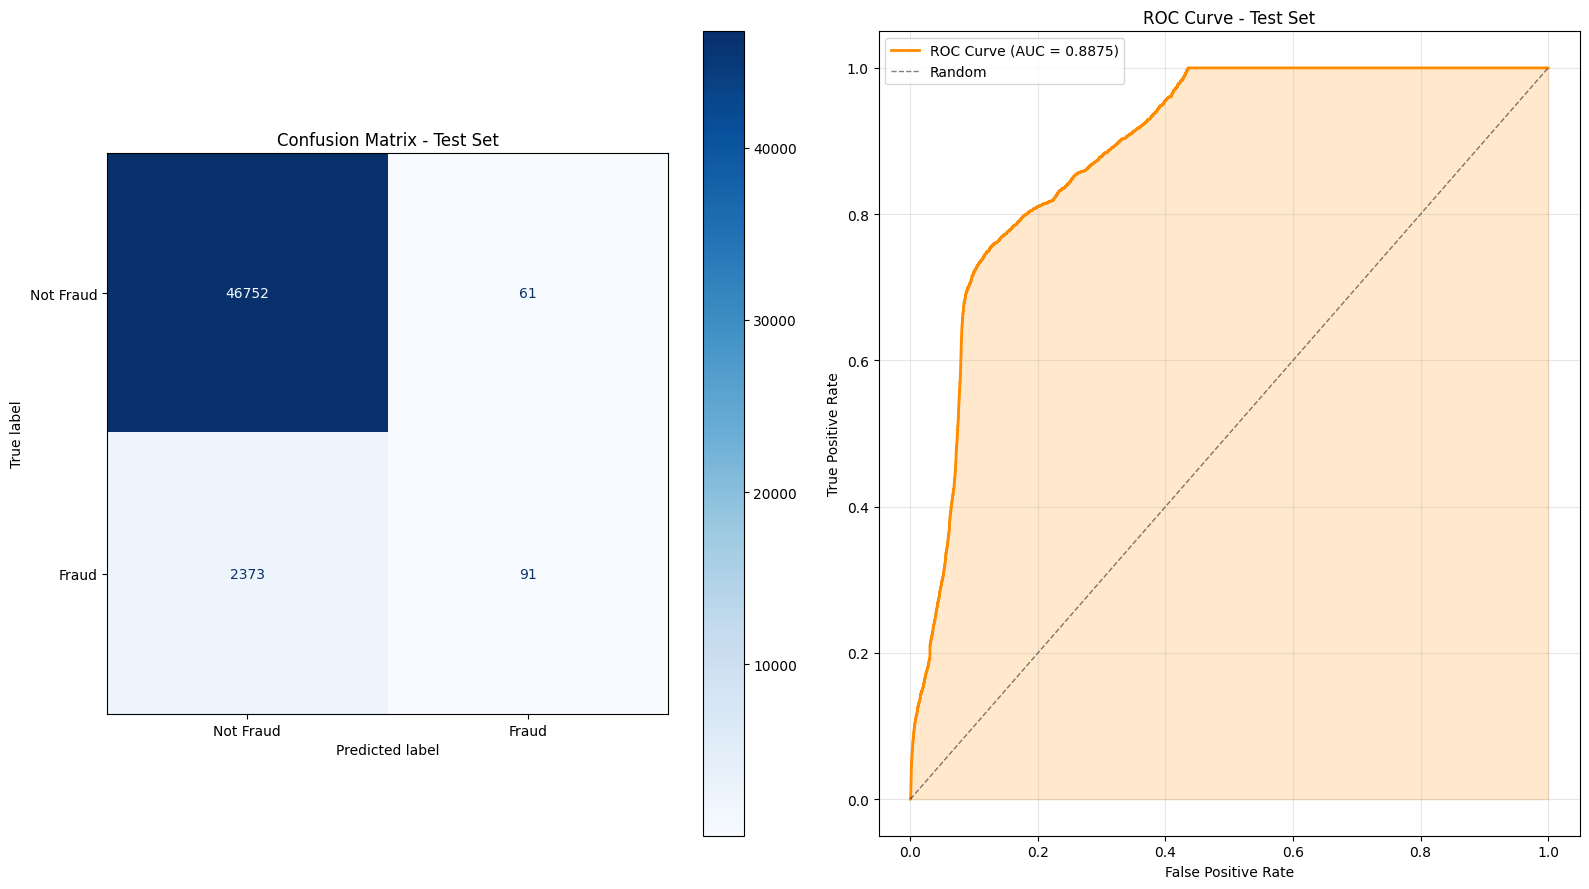


We are talking about weights [1.0, 5.0]

Using class weights: negative=1.00, positive=5.00
BCEWithLogitsLoss pos_weight: 5.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 727.27it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:00<00:00, 776.21it/s]


Test Loss: 0.3885, Acc: 0.9026, Prec: 0.2429, Rec: 0.4476, AUC: 0.8877

Epoch 1/20:
  Train Loss: 0.3930, Acc: 0.9069, Prec: 0.2513, Rec: 0.4357, AUC: 0.8840
  Val Loss: 0.3872, Acc: 0.9040, Prec: 0.2464, Rec: 0.4470, AUC: 0.8855
--------------------------------------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 654.32it/s]


Epoch 2/20:
  Train Loss: 0.3907, Acc: 0.9034, Prec: 0.2446, Rec: 0.4466, AUC: 0.8867
  Val Loss: 0.3895, Acc: 0.9082, Prec: 0.2322, Rec: 0.3626, AUC: 0.8857
--------------------------------------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 719.75it/s]


Epoch 3/20:
  Train Loss: 0.3903, Acc: 0.9028, Prec: 0.2414, Rec: 0.4405, AUC: 0.8867
  Val Loss: 0.3872, Acc: 0.9033, Prec: 0.2426, Rec: 0.4400, AUC: 0.8857
--------------------------------------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 740.29it/s]


Epoch 4/20:
  Train Loss: 0.3909, Acc: 0.9024, Prec: 0.2388, Rec: 0.4351, AUC: 0.8870
  Val Loss: 0.3872, Acc: 0.9030, Prec: 0.2404, Rec: 0.4348, AUC: 0.8859
--------------------------------------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 581.06it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 5:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 644.52it/s]


Test Loss: 0.3899, Acc: 0.8993, Prec: 0.2485, Rec: 0.5004, AUC: 0.8877

Epoch 5/20:
  Train Loss: 0.3906, Acc: 0.9023, Prec: 0.2410, Rec: 0.4442, AUC: 0.8866
  Val Loss: 0.3877, Acc: 0.9009, Prec: 0.2538, Rec: 0.5061, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 660.57it/s]


Epoch 6/20:
  Train Loss: 0.3905, Acc: 0.9015, Prec: 0.2382, Rec: 0.4414, AUC: 0.8872
  Val Loss: 0.3878, Acc: 0.9027, Prec: 0.2429, Rec: 0.4470, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 637.55it/s]


Epoch 7/20:
  Train Loss: 0.3904, Acc: 0.9026, Prec: 0.2403, Rec: 0.4390, AUC: 0.8873
  Val Loss: 0.3876, Acc: 0.9015, Prec: 0.2546, Rec: 0.5035, AUC: 0.8859
--------------------------------------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 660.40it/s]


Epoch 8/20:
  Train Loss: 0.3909, Acc: 0.9022, Prec: 0.2387, Rec: 0.4364, AUC: 0.8871
  Val Loss: 0.3873, Acc: 0.9022, Prec: 0.2370, Rec: 0.4304, AUC: 0.8861
--------------------------------------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 697.14it/s]


Epoch 9/20:
  Train Loss: 0.3907, Acc: 0.9016, Prec: 0.2395, Rec: 0.4455, AUC: 0.8868
  Val Loss: 0.3869, Acc: 0.9018, Prec: 0.2466, Rec: 0.4687, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 752.57it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 10:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 761.43it/s]


Test Loss: 0.3907, Acc: 0.8994, Prec: 0.2482, Rec: 0.4988, AUC: 0.8877

Epoch 10/20:
  Train Loss: 0.3902, Acc: 0.9015, Prec: 0.2396, Rec: 0.4462, AUC: 0.8870
  Val Loss: 0.3886, Acc: 0.9009, Prec: 0.2533, Rec: 0.5043, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 737.51it/s]


Epoch 11/20:
  Train Loss: 0.3902, Acc: 0.9019, Prec: 0.2407, Rec: 0.4462, AUC: 0.8871
  Val Loss: 0.3883, Acc: 0.9024, Prec: 0.2281, Rec: 0.3991, AUC: 0.8862
--------------------------------------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 726.22it/s]


Epoch 12/20:
  Train Loss: 0.3906, Acc: 0.9016, Prec: 0.2385, Rec: 0.4416, AUC: 0.8870
  Val Loss: 0.3869, Acc: 0.9019, Prec: 0.2454, Rec: 0.4635, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 707.04it/s]


Epoch 13/20:
  Train Loss: 0.3902, Acc: 0.9010, Prec: 0.2377, Rec: 0.4436, AUC: 0.8873
  Val Loss: 0.3873, Acc: 0.9007, Prec: 0.2492, Rec: 0.4896, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 729.88it/s]


Epoch 14/20:
  Train Loss: 0.3904, Acc: 0.9027, Prec: 0.2412, Rec: 0.4412, AUC: 0.8874
  Val Loss: 0.3880, Acc: 0.9017, Prec: 0.2327, Rec: 0.4200, AUC: 0.8862
--------------------------------------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 730.40it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 15:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 722.86it/s]


Test Loss: 0.3893, Acc: 0.8996, Prec: 0.2344, Rec: 0.4444, AUC: 0.8877

Epoch 15/20:
  Train Loss: 0.3899, Acc: 0.9017, Prec: 0.2403, Rec: 0.4468, AUC: 0.8872
  Val Loss: 0.3872, Acc: 0.9019, Prec: 0.2439, Rec: 0.4574, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 685.76it/s]


Epoch 16/20:
  Train Loss: 0.3904, Acc: 0.9018, Prec: 0.2413, Rec: 0.4497, AUC: 0.8865
  Val Loss: 0.3883, Acc: 0.9030, Prec: 0.2299, Rec: 0.4000, AUC: 0.8861
--------------------------------------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 751.21it/s]


Epoch 17/20:
  Train Loss: 0.3904, Acc: 0.9024, Prec: 0.2415, Rec: 0.4453, AUC: 0.8871
  Val Loss: 0.3887, Acc: 0.9035, Prec: 0.2281, Rec: 0.3896, AUC: 0.8861
--------------------------------------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 712.45it/s]


Epoch 18/20:
  Train Loss: 0.3905, Acc: 0.9014, Prec: 0.2389, Rec: 0.4444, AUC: 0.8870
  Val Loss: 0.3882, Acc: 0.9035, Prec: 0.2322, Rec: 0.4035, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 736.35it/s]


Epoch 19/20:
  Train Loss: 0.3906, Acc: 0.9020, Prec: 0.2406, Rec: 0.4449, AUC: 0.8869
  Val Loss: 0.3870, Acc: 0.9019, Prec: 0.2445, Rec: 0.4600, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 657.04it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 20:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 751.85it/s]


Test Loss: 0.3965, Acc: 0.9001, Prec: 0.2652, Rec: 0.5633, AUC: 0.8877

Epoch 20/20:
  Train Loss: 0.3903, Acc: 0.9017, Prec: 0.2379, Rec: 0.4386, AUC: 0.8871
  Val Loss: 0.3941, Acc: 0.9028, Prec: 0.2759, Rec: 0.5809, AUC: 0.8860
--------------------------------------------------------------------------------


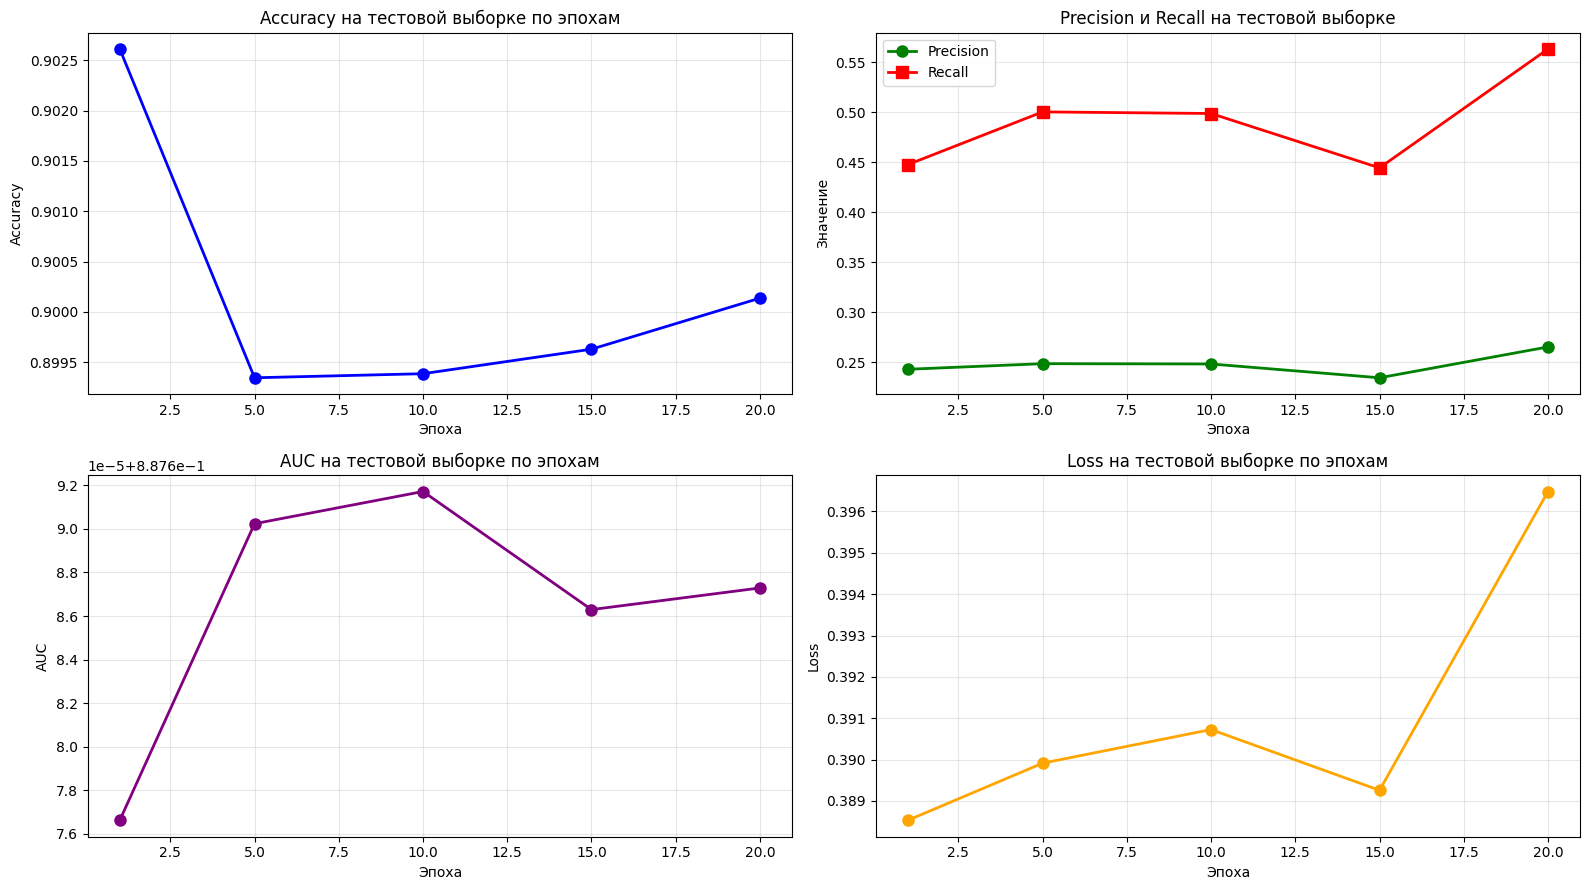

1        0.3885     0.9026     0.2429     0.4476     0.8877    
5        0.3899     0.8993     0.2485     0.5004     0.8877    
10       0.3907     0.8994     0.2482     0.4988     0.8877    
15       0.3893     0.8996     0.2344     0.4444     0.8877    
20       0.3965     0.9001     0.2652     0.5633     0.8877    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.8877 на эпохе 10
Лучшая Accuracy: 0.9026 на эпохе 1


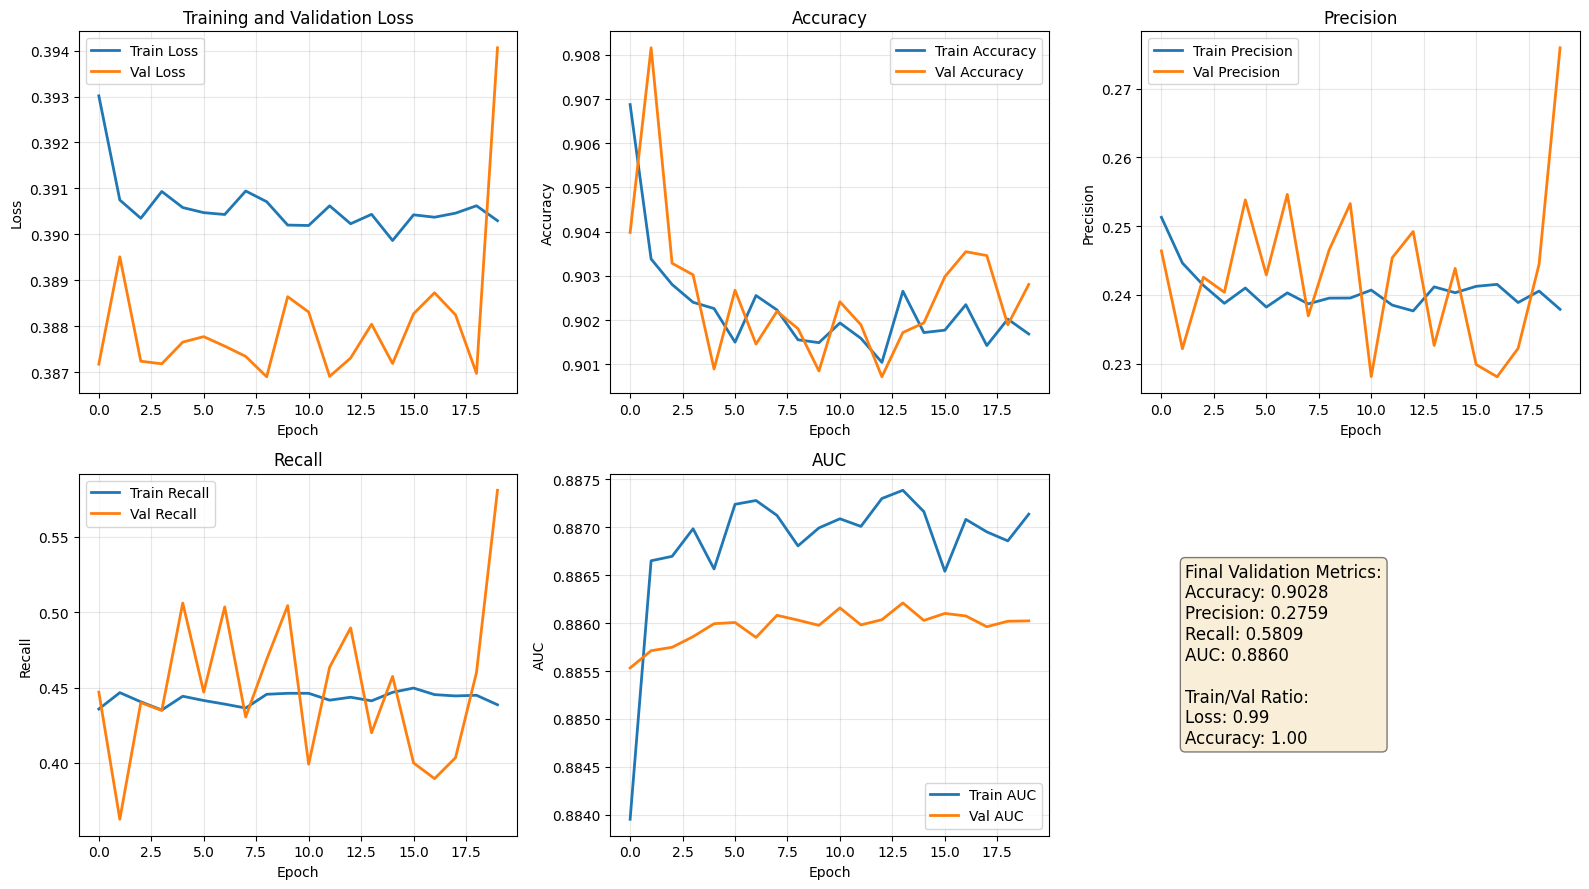

Testing: 100%|██████████| 770/770 [00:00<00:00, 828.57it/s]



TEST SET RESULTS:
Accuracy:  0.9001
Precision: 0.2652
Recall:    0.5633
AUC:       0.8877
F1-Score:  0.3607


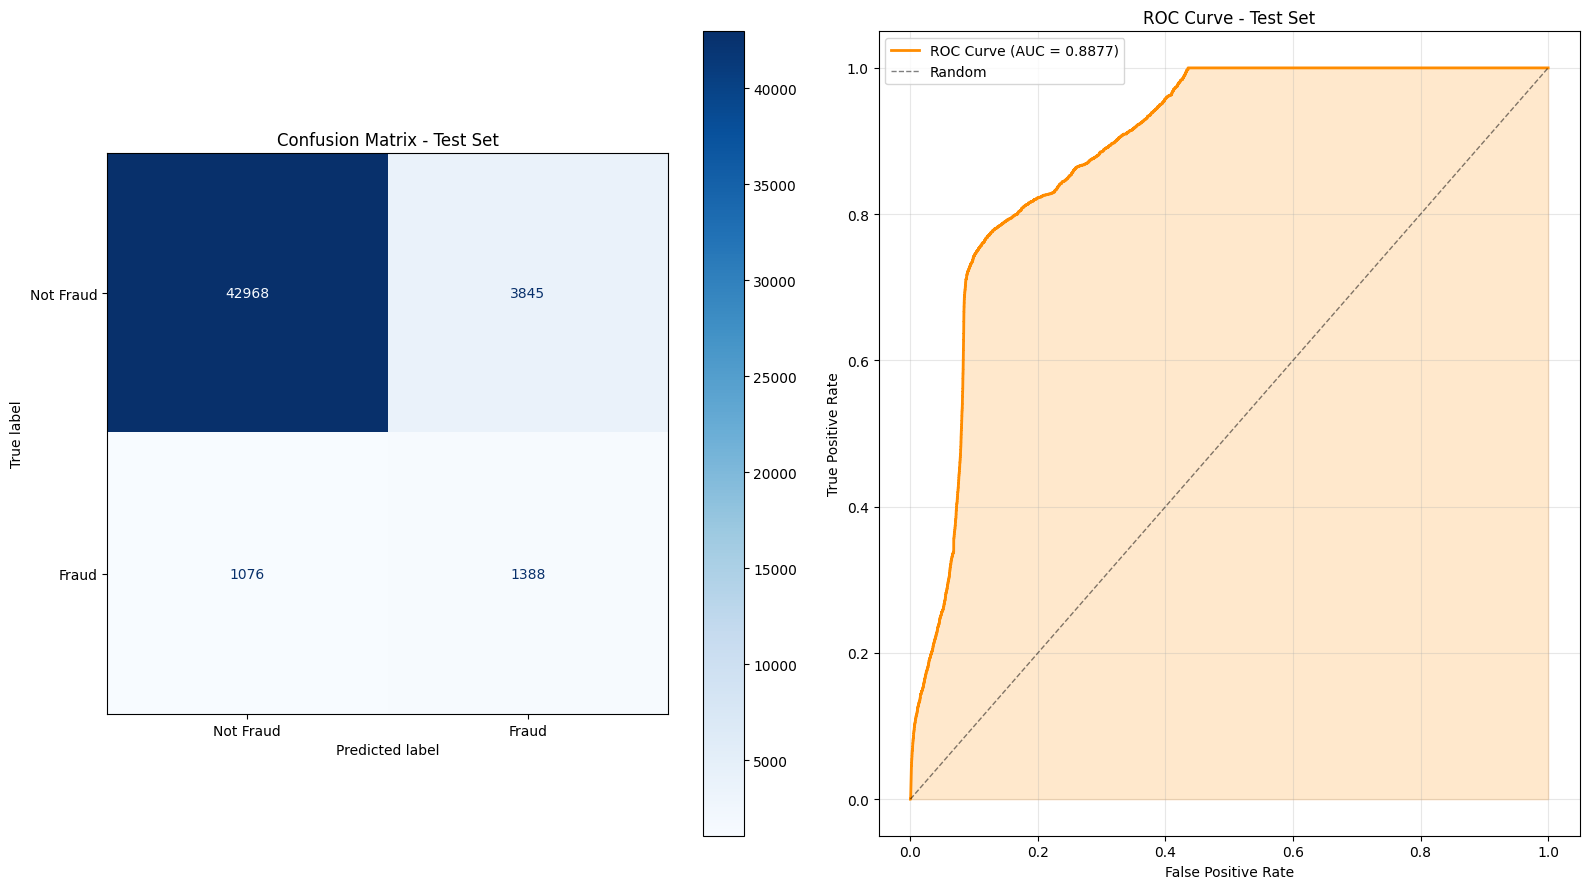


We are talking about weights [1.0, 10.0]

Using class weights: negative=1.00, positive=10.00
BCEWithLogitsLoss pos_weight: 10.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 728.71it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 766.46it/s]


Test Loss: 0.5585, Acc: 0.8774, Prec: 0.2564, Rec: 0.7638, AUC: 0.8877

Epoch 1/20:
  Train Loss: 0.5591, Acc: 0.8897, Prec: 0.2694, Rec: 0.7045, AUC: 0.8865
  Val Loss: 0.5553, Acc: 0.8793, Prec: 0.2558, Rec: 0.7400, AUC: 0.8861
--------------------------------------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 780.41it/s]


Epoch 2/20:
  Train Loss: 0.5589, Acc: 0.8938, Prec: 0.2801, Rec: 0.7154, AUC: 0.8873
  Val Loss: 0.5593, Acc: 0.9040, Prec: 0.2914, Rec: 0.6417, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 727.08it/s]


Epoch 3/20:
  Train Loss: 0.5584, Acc: 0.8973, Prec: 0.2863, Rec: 0.7065, AUC: 0.8871
  Val Loss: 0.5538, Acc: 0.9015, Prec: 0.2986, Rec: 0.7191, AUC: 0.8862
--------------------------------------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 684.69it/s]


Epoch 4/20:
  Train Loss: 0.5587, Acc: 0.8979, Prec: 0.2884, Rec: 0.7106, AUC: 0.8870
  Val Loss: 0.5551, Acc: 0.9048, Prec: 0.3036, Rec: 0.6983, AUC: 0.8860
--------------------------------------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 737.27it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 5:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 742.29it/s]


Test Loss: 0.5588, Acc: 0.8970, Prec: 0.2903, Rec: 0.7338, AUC: 0.8878

Epoch 5/20:
  Train Loss: 0.5588, Acc: 0.8965, Prec: 0.2850, Rec: 0.7095, AUC: 0.8871
  Val Loss: 0.5549, Acc: 0.8981, Prec: 0.2917, Rec: 0.7270, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 745.30it/s]


Epoch 6/20:
  Train Loss: 0.5589, Acc: 0.8979, Prec: 0.2878, Rec: 0.7067, AUC: 0.8874
  Val Loss: 0.5554, Acc: 0.8721, Prec: 0.2460, Rec: 0.7539, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 731.83it/s]


Epoch 7/20:
  Train Loss: 0.5586, Acc: 0.8972, Prec: 0.2856, Rec: 0.7034, AUC: 0.8868
  Val Loss: 0.5538, Acc: 0.9045, Prec: 0.3042, Rec: 0.7070, AUC: 0.8862
--------------------------------------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 638.47it/s]


Epoch 8/20:
  Train Loss: 0.5587, Acc: 0.8968, Prec: 0.2847, Rec: 0.7038, AUC: 0.8869
  Val Loss: 0.5559, Acc: 0.9042, Prec: 0.2945, Rec: 0.6557, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 678.24it/s]


Epoch 9/20:
  Train Loss: 0.5586, Acc: 0.8972, Prec: 0.2861, Rec: 0.7067, AUC: 0.8873
  Val Loss: 0.5560, Acc: 0.8805, Prec: 0.2588, Rec: 0.7452, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 700.70it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 10:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 757.36it/s]


Test Loss: 0.5579, Acc: 0.8925, Prec: 0.2823, Rec: 0.7451, AUC: 0.8877

Epoch 10/20:
  Train Loss: 0.5589, Acc: 0.8997, Prec: 0.2918, Rec: 0.7049, AUC: 0.8871
  Val Loss: 0.5543, Acc: 0.8932, Prec: 0.2813, Rec: 0.7296, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 731.72it/s]


Epoch 11/20:
  Train Loss: 0.5586, Acc: 0.8949, Prec: 0.2806, Rec: 0.7041, AUC: 0.8870
  Val Loss: 0.5538, Acc: 0.9049, Prec: 0.3042, Rec: 0.7000, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 753.78it/s]


Epoch 12/20:
  Train Loss: 0.5587, Acc: 0.8975, Prec: 0.2865, Rec: 0.7052, AUC: 0.8873
  Val Loss: 0.5539, Acc: 0.9052, Prec: 0.3046, Rec: 0.6983, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 675.76it/s]


Epoch 13/20:
  Train Loss: 0.5598, Acc: 0.8990, Prec: 0.2899, Rec: 0.7032, AUC: 0.8875
  Val Loss: 0.5557, Acc: 0.8715, Prec: 0.2452, Rec: 0.7548, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 705.52it/s]


Epoch 14/20:
  Train Loss: 0.5585, Acc: 0.8955, Prec: 0.2822, Rec: 0.7065, AUC: 0.8869
  Val Loss: 0.5553, Acc: 0.9045, Prec: 0.3040, Rec: 0.7052, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 707.46it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 15:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 741.30it/s]


Test Loss: 0.5594, Acc: 0.8662, Prec: 0.2407, Rec: 0.7780, AUC: 0.8877

Epoch 15/20:
  Train Loss: 0.5584, Acc: 0.8987, Prec: 0.2892, Rec: 0.7032, AUC: 0.8870
  Val Loss: 0.5556, Acc: 0.8672, Prec: 0.2393, Rec: 0.7600, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 771.37it/s]


Epoch 16/20:
  Train Loss: 0.5587, Acc: 0.8984, Prec: 0.2885, Rec: 0.7034, AUC: 0.8874
  Val Loss: 0.5619, Acc: 0.8304, Prec: 0.1996, Rec: 0.7948, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 737.64it/s]


Epoch 17/20:
  Train Loss: 0.5587, Acc: 0.8972, Prec: 0.2862, Rec: 0.7071, AUC: 0.8873
  Val Loss: 0.5545, Acc: 0.9044, Prec: 0.3040, Rec: 0.7070, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 759.89it/s]


Epoch 18/20:
  Train Loss: 0.5591, Acc: 0.8980, Prec: 0.2873, Rec: 0.7023, AUC: 0.8874
  Val Loss: 0.5550, Acc: 0.9039, Prec: 0.3030, Rec: 0.7087, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 677.40it/s]


Epoch 19/20:
  Train Loss: 0.5582, Acc: 0.8976, Prec: 0.2863, Rec: 0.7025, AUC: 0.8872
  Val Loss: 0.5549, Acc: 0.9053, Prec: 0.3017, Rec: 0.6800, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 786.82it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 20:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 752.35it/s]


Test Loss: 0.5578, Acc: 0.8989, Prec: 0.2941, Rec: 0.7297, AUC: 0.8877

Epoch 20/20:
  Train Loss: 0.5594, Acc: 0.8983, Prec: 0.2884, Rec: 0.7045, AUC: 0.8872
  Val Loss: 0.5542, Acc: 0.8994, Prec: 0.2938, Rec: 0.7209, AUC: 0.8863
--------------------------------------------------------------------------------


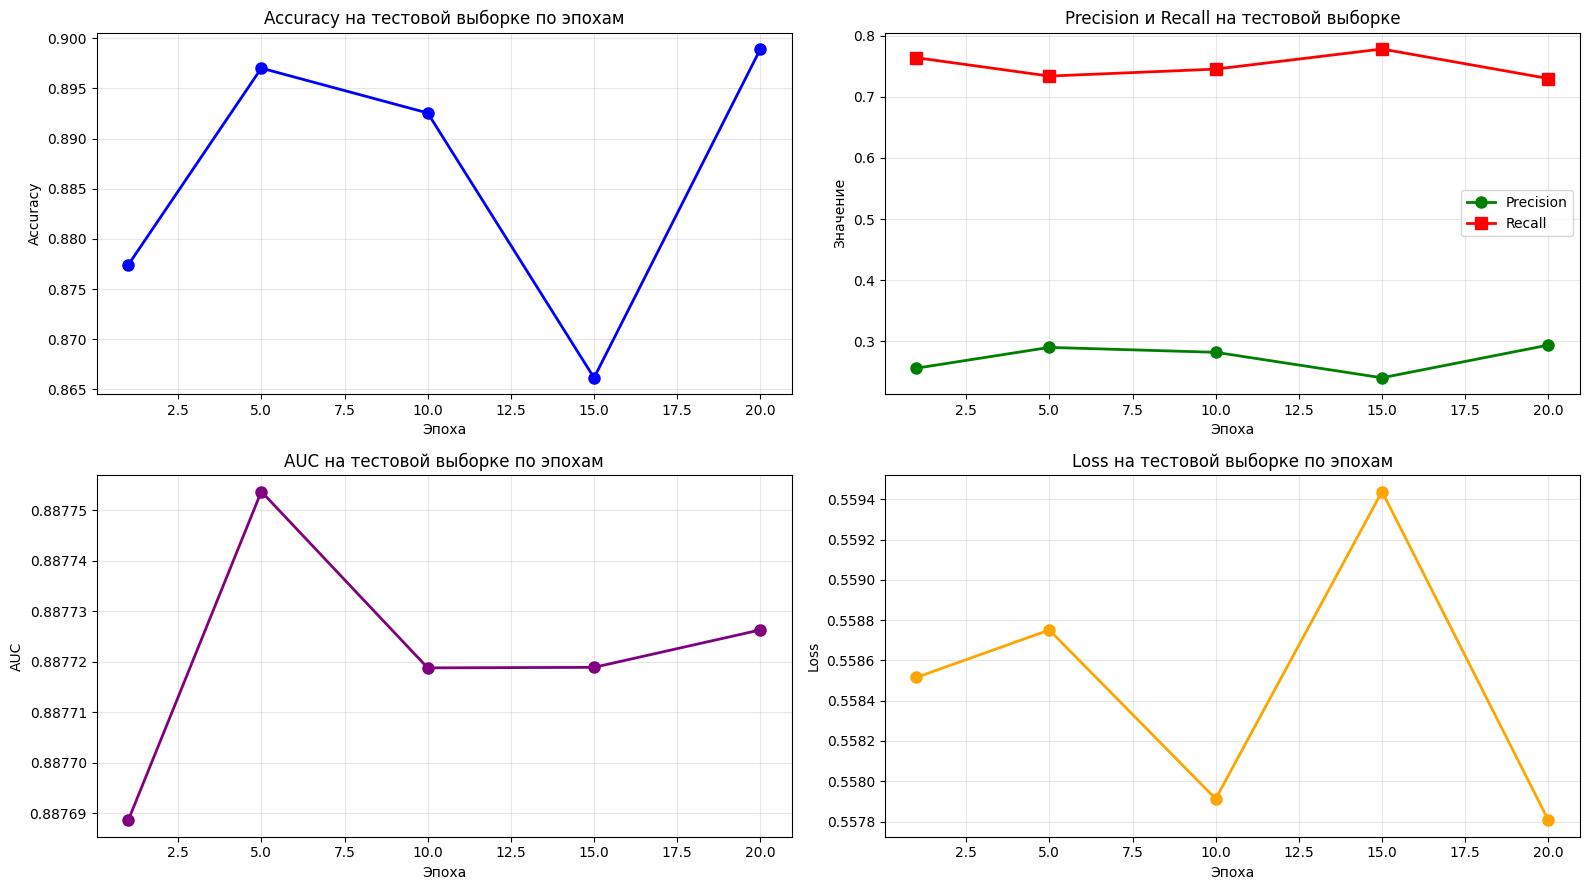

1        0.5585     0.8774     0.2564     0.7638     0.8877    
5        0.5588     0.8970     0.2903     0.7338     0.8878    
10       0.5579     0.8925     0.2823     0.7451     0.8877    
15       0.5594     0.8662     0.2407     0.7780     0.8877    
20       0.5578     0.8989     0.2941     0.7297     0.8877    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.8878 на эпохе 5
Лучшая Accuracy: 0.8989 на эпохе 20


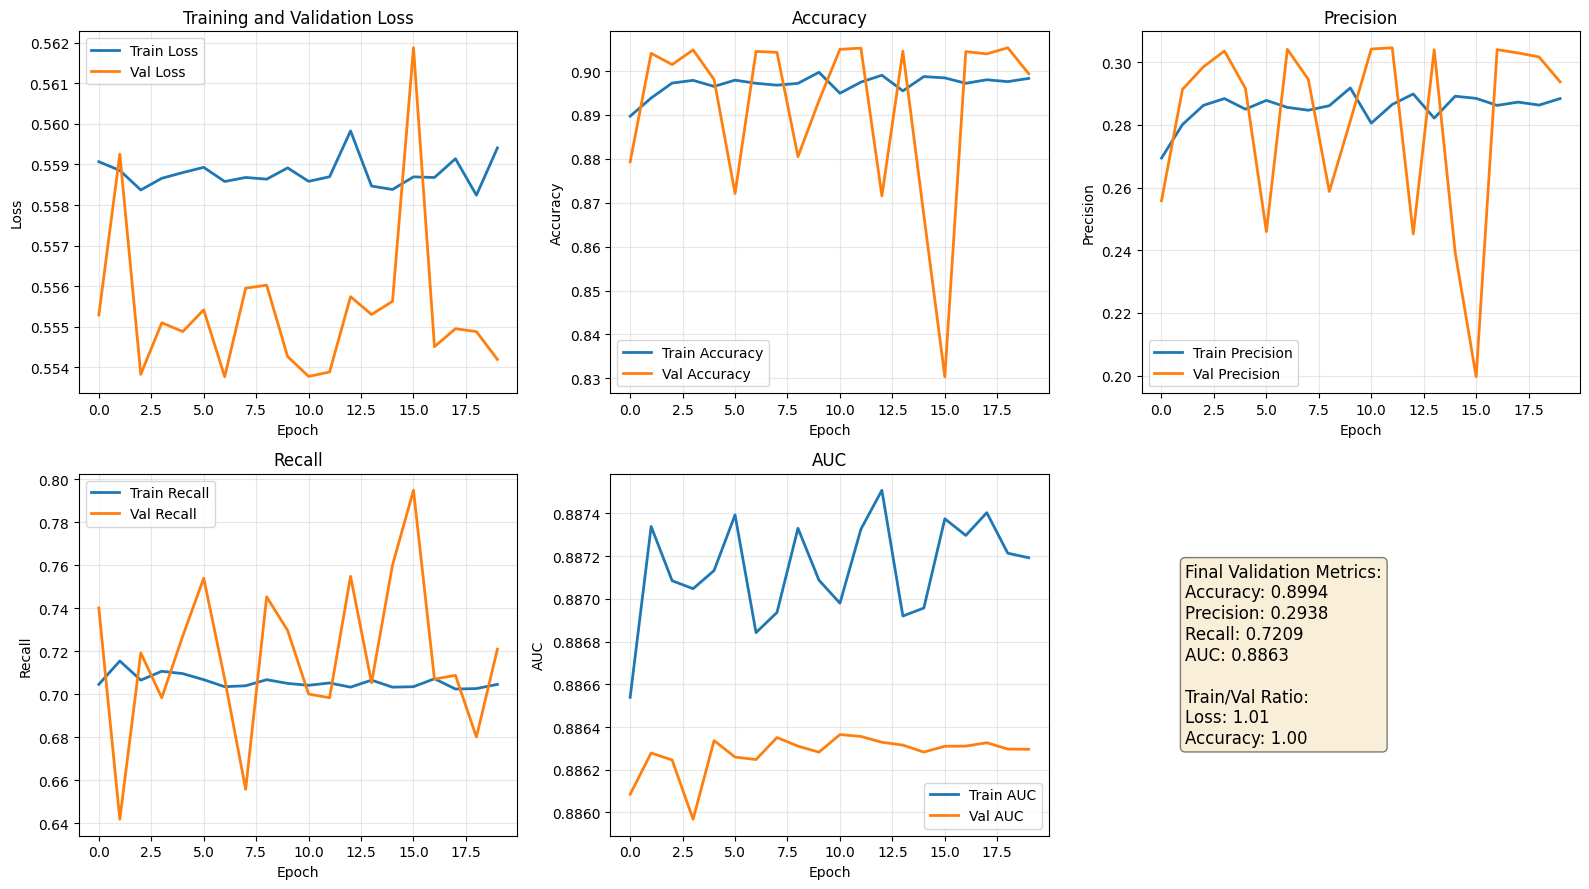

Testing: 100%|██████████| 770/770 [00:00<00:00, 896.65it/s]



TEST SET RESULTS:
Accuracy:  0.8989
Precision: 0.2941
Recall:    0.7297
AUC:       0.8877
F1-Score:  0.4193


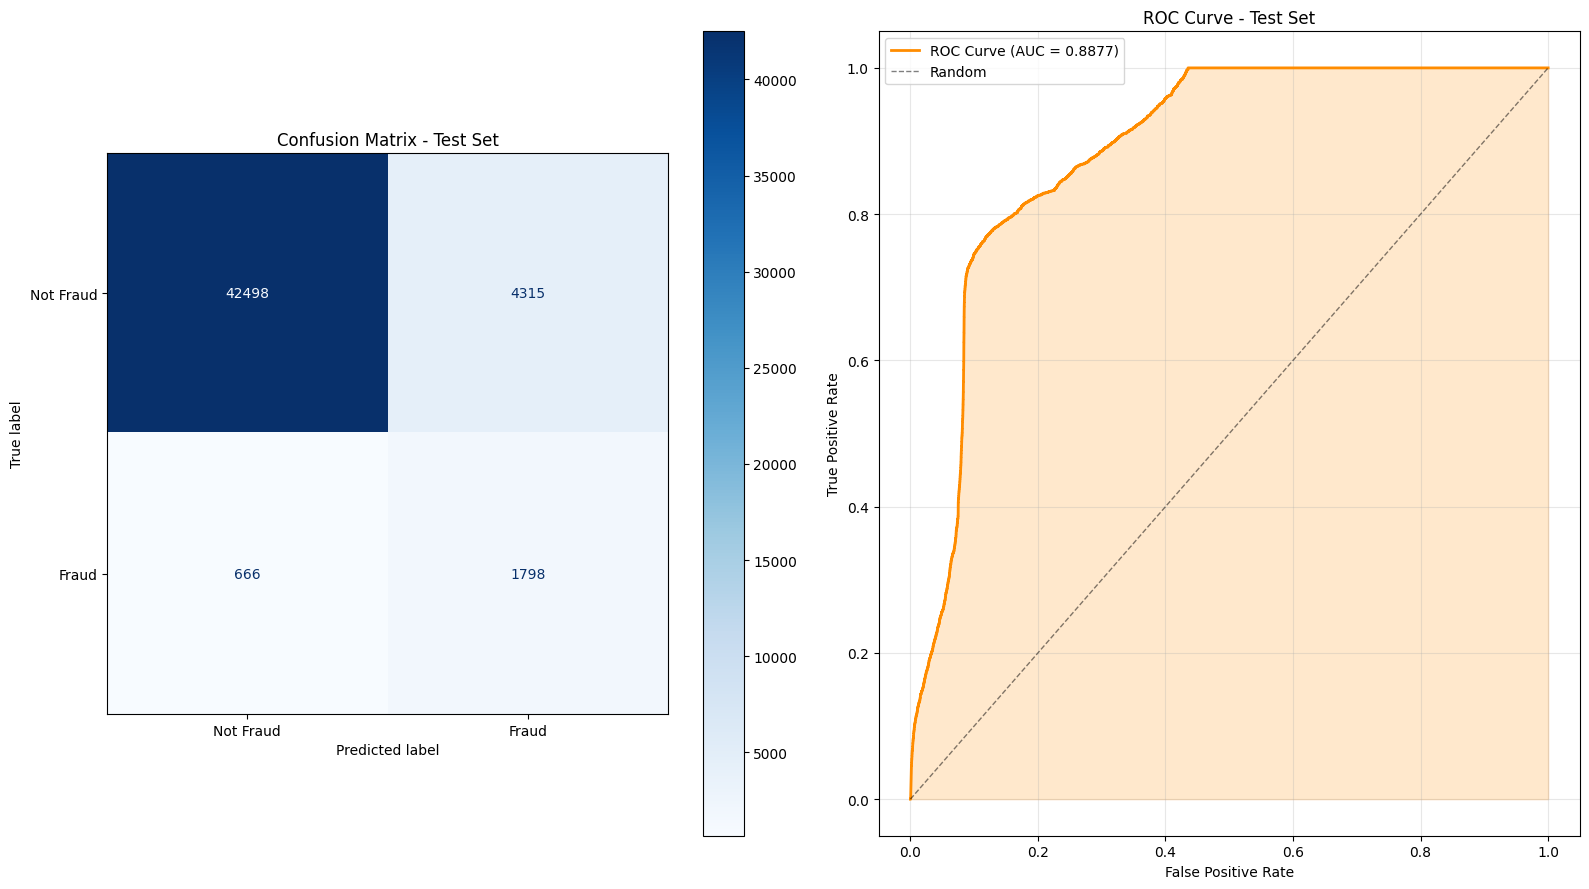


We are talking about weights [1.0, 20.0]

Using class weights: negative=1.00, positive=20.00
BCEWithLogitsLoss pos_weight: 20.00
--------------------------------------------------------------------------------


Epoch 1/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 536.23it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 1:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 739.22it/s]


Test Loss: 0.7658, Acc: 0.6412, Prec: 0.1162, Rec: 0.9351, AUC: 0.8877

Epoch 1/20:
  Train Loss: 0.7670, Acc: 0.6598, Prec: 0.1200, Rec: 0.9167, AUC: 0.8866
  Val Loss: 0.7612, Acc: 0.6455, Prec: 0.1168, Rec: 0.9278, AUC: 0.8863
--------------------------------------------------------------------------------


Epoch 2/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 723.62it/s]


Epoch 2/20:
  Train Loss: 0.7652, Acc: 0.6469, Prec: 0.1172, Rec: 0.9282, AUC: 0.8865
  Val Loss: 0.7595, Acc: 0.6463, Prec: 0.1170, Rec: 0.9278, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 3/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 747.62it/s]


Epoch 3/20:
  Train Loss: 0.7650, Acc: 0.6442, Prec: 0.1169, Rec: 0.9330, AUC: 0.8871
  Val Loss: 0.7606, Acc: 0.6257, Prec: 0.1128, Rec: 0.9443, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 4/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 761.91it/s]


Epoch 4/20:
  Train Loss: 0.7643, Acc: 0.6393, Prec: 0.1159, Rec: 0.9376, AUC: 0.8871
  Val Loss: 0.7589, Acc: 0.6515, Prec: 0.1182, Rec: 0.9243, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 5/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 692.73it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 5:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 693.15it/s]


Test Loss: 0.7668, Acc: 0.7002, Prec: 0.1317, Rec: 0.8933, AUC: 0.8879

Epoch 5/20:
  Train Loss: 0.7645, Acc: 0.6431, Prec: 0.1168, Rec: 0.9356, AUC: 0.8865
  Val Loss: 0.7610, Acc: 0.7035, Prec: 0.1323, Rec: 0.8870, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 6/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 768.07it/s]


Epoch 6/20:
  Train Loss: 0.7647, Acc: 0.6452, Prec: 0.1172, Rec: 0.9330, AUC: 0.8870
  Val Loss: 0.7586, Acc: 0.6618, Prec: 0.1201, Rec: 0.9113, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 7/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 783.04it/s]


Epoch 7/20:
  Train Loss: 0.7649, Acc: 0.6431, Prec: 0.1167, Rec: 0.9343, AUC: 0.8874
  Val Loss: 0.7575, Acc: 0.6419, Prec: 0.1161, Rec: 0.9313, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 8/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 723.78it/s]


Epoch 8/20:
  Train Loss: 0.7643, Acc: 0.6414, Prec: 0.1162, Rec: 0.9348, AUC: 0.8872
  Val Loss: 0.7579, Acc: 0.6592, Prec: 0.1196, Rec: 0.9139, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 9/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 759.64it/s]


Epoch 9/20:
  Train Loss: 0.7641, Acc: 0.6456, Prec: 0.1175, Rec: 0.9354, AUC: 0.8868
  Val Loss: 0.7579, Acc: 0.6458, Prec: 0.1169, Rec: 0.9278, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 10/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 787.32it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 10:


Testing on Test Set: 100%|██████████| 770/770 [00:00<00:00, 771.09it/s]


Test Loss: 0.7639, Acc: 0.6343, Prec: 0.1149, Rec: 0.9420, AUC: 0.8878

Epoch 10/20:
  Train Loss: 0.7654, Acc: 0.6417, Prec: 0.1166, Rec: 0.9374, AUC: 0.8869
  Val Loss: 0.7582, Acc: 0.6382, Prec: 0.1152, Rec: 0.9330, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 11/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 787.41it/s]


Epoch 11/20:
  Train Loss: 0.7654, Acc: 0.6413, Prec: 0.1165, Rec: 0.9378, AUC: 0.8864
  Val Loss: 0.7583, Acc: 0.6514, Prec: 0.1182, Rec: 0.9243, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 12/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 794.27it/s]


Epoch 12/20:
  Train Loss: 0.7654, Acc: 0.6444, Prec: 0.1167, Rec: 0.9302, AUC: 0.8868
  Val Loss: 0.7619, Acc: 0.6358, Prec: 0.1147, Rec: 0.9348, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 13/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 782.00it/s]


Epoch 13/20:
  Train Loss: 0.7638, Acc: 0.6386, Prec: 0.1158, Rec: 0.9391, AUC: 0.8875
  Val Loss: 0.7580, Acc: 0.6351, Prec: 0.1146, Rec: 0.9365, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 14/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 750.26it/s]


Epoch 14/20:
  Train Loss: 0.7642, Acc: 0.6411, Prec: 0.1162, Rec: 0.9354, AUC: 0.8876
  Val Loss: 0.7590, Acc: 0.6190, Prec: 0.1118, Rec: 0.9530, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 15/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 717.22it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 15:


Testing on Test Set: 100%|██████████| 770/770 [00:00<00:00, 771.03it/s]


Test Loss: 0.7640, Acc: 0.6482, Prec: 0.1177, Rec: 0.9294, AUC: 0.8879

Epoch 15/20:
  Train Loss: 0.7650, Acc: 0.6374, Prec: 0.1153, Rec: 0.9363, AUC: 0.8867
  Val Loss: 0.7581, Acc: 0.6517, Prec: 0.1181, Rec: 0.9226, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 16/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 752.00it/s]


Epoch 16/20:
  Train Loss: 0.7645, Acc: 0.6430, Prec: 0.1169, Rec: 0.9365, AUC: 0.8873
  Val Loss: 0.7587, Acc: 0.6302, Prec: 0.1138, Rec: 0.9417, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 17/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 739.61it/s]


Epoch 17/20:
  Train Loss: 0.7650, Acc: 0.6371, Prec: 0.1153, Rec: 0.9382, AUC: 0.8872
  Val Loss: 0.7599, Acc: 0.6772, Prec: 0.1241, Rec: 0.9009, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 18/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 700.86it/s]


Epoch 18/20:
  Train Loss: 0.7645, Acc: 0.6410, Prec: 0.1162, Rec: 0.9352, AUC: 0.8874
  Val Loss: 0.7588, Acc: 0.6308, Prec: 0.1138, Rec: 0.9409, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 19/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 719.57it/s]


Epoch 19/20:
  Train Loss: 0.7642, Acc: 0.6391, Prec: 0.1160, Rec: 0.9389, AUC: 0.8876
  Val Loss: 0.7579, Acc: 0.6289, Prec: 0.1135, Rec: 0.9426, AUC: 0.8864
--------------------------------------------------------------------------------


Epoch 20/20 - Val: 100%|██████████| 360/360 [00:00<00:00, 781.77it/s]



ТЕСТИРОВАНИЕ НА ЭПОХЕ 20:


Testing on Test Set: 100%|██████████| 770/770 [00:01<00:00, 758.31it/s]


Test Loss: 0.7639, Acc: 0.6322, Prec: 0.1145, Rec: 0.9436, AUC: 0.8878

Epoch 20/20:
  Train Loss: 0.7641, Acc: 0.6398, Prec: 0.1160, Rec: 0.9367, AUC: 0.8875
  Val Loss: 0.7582, Acc: 0.6357, Prec: 0.1147, Rec: 0.9357, AUC: 0.8864
--------------------------------------------------------------------------------


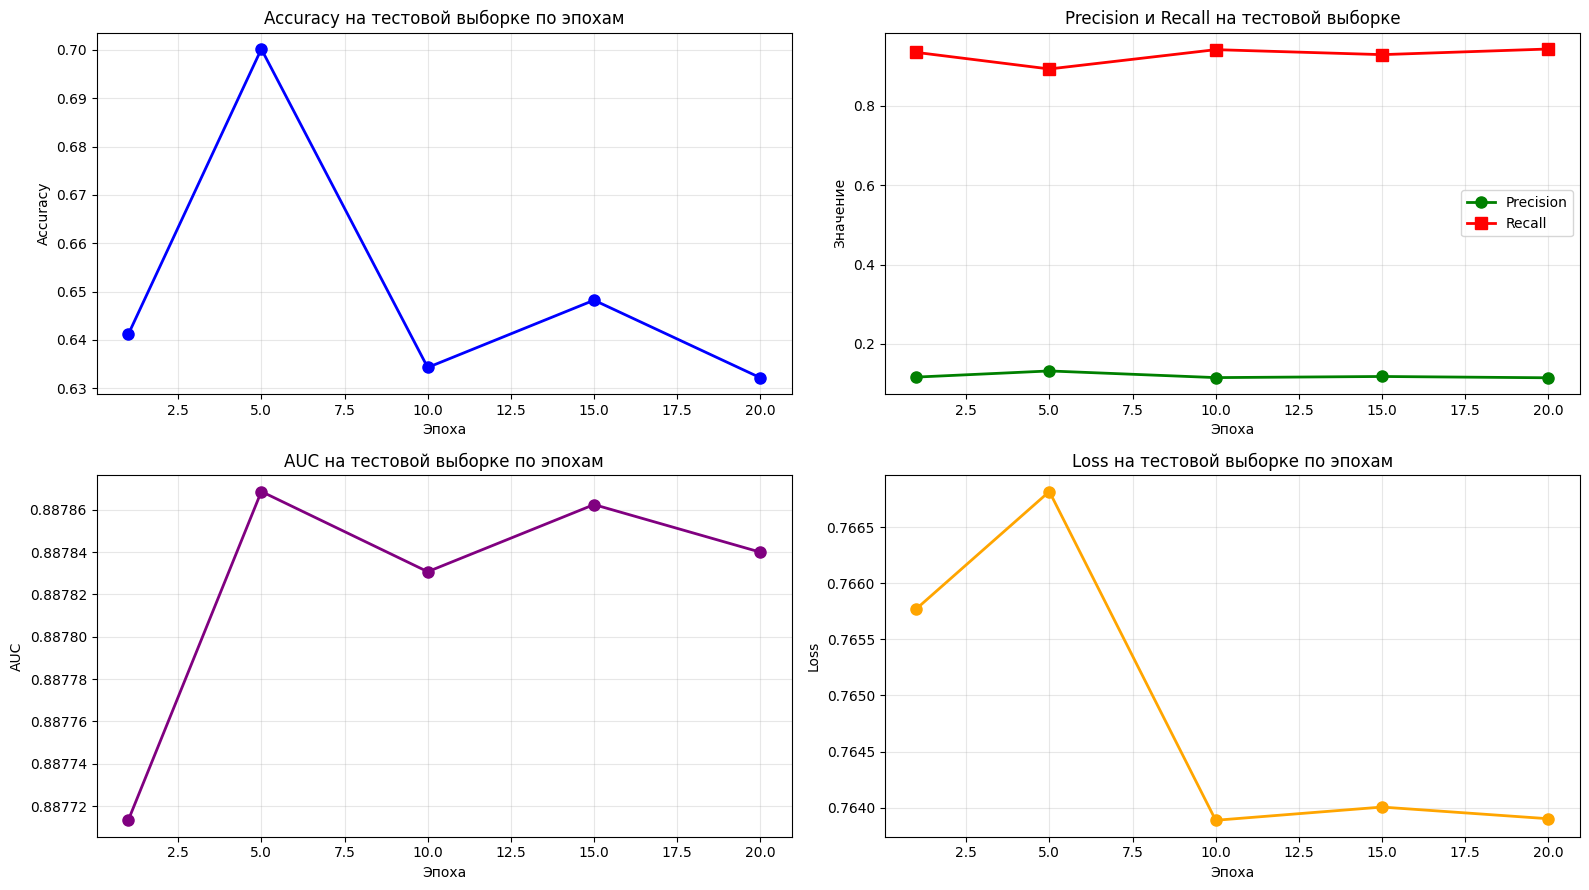

1        0.7658     0.6412     0.1162     0.9351     0.8877    
5        0.7668     0.7002     0.1317     0.8933     0.8879    
10       0.7639     0.6343     0.1149     0.9420     0.8878    
15       0.7640     0.6482     0.1177     0.9294     0.8879    
20       0.7639     0.6322     0.1145     0.9436     0.8878    

ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Лучший AUC: 0.8879 на эпохе 5
Лучшая Accuracy: 0.7002 на эпохе 5


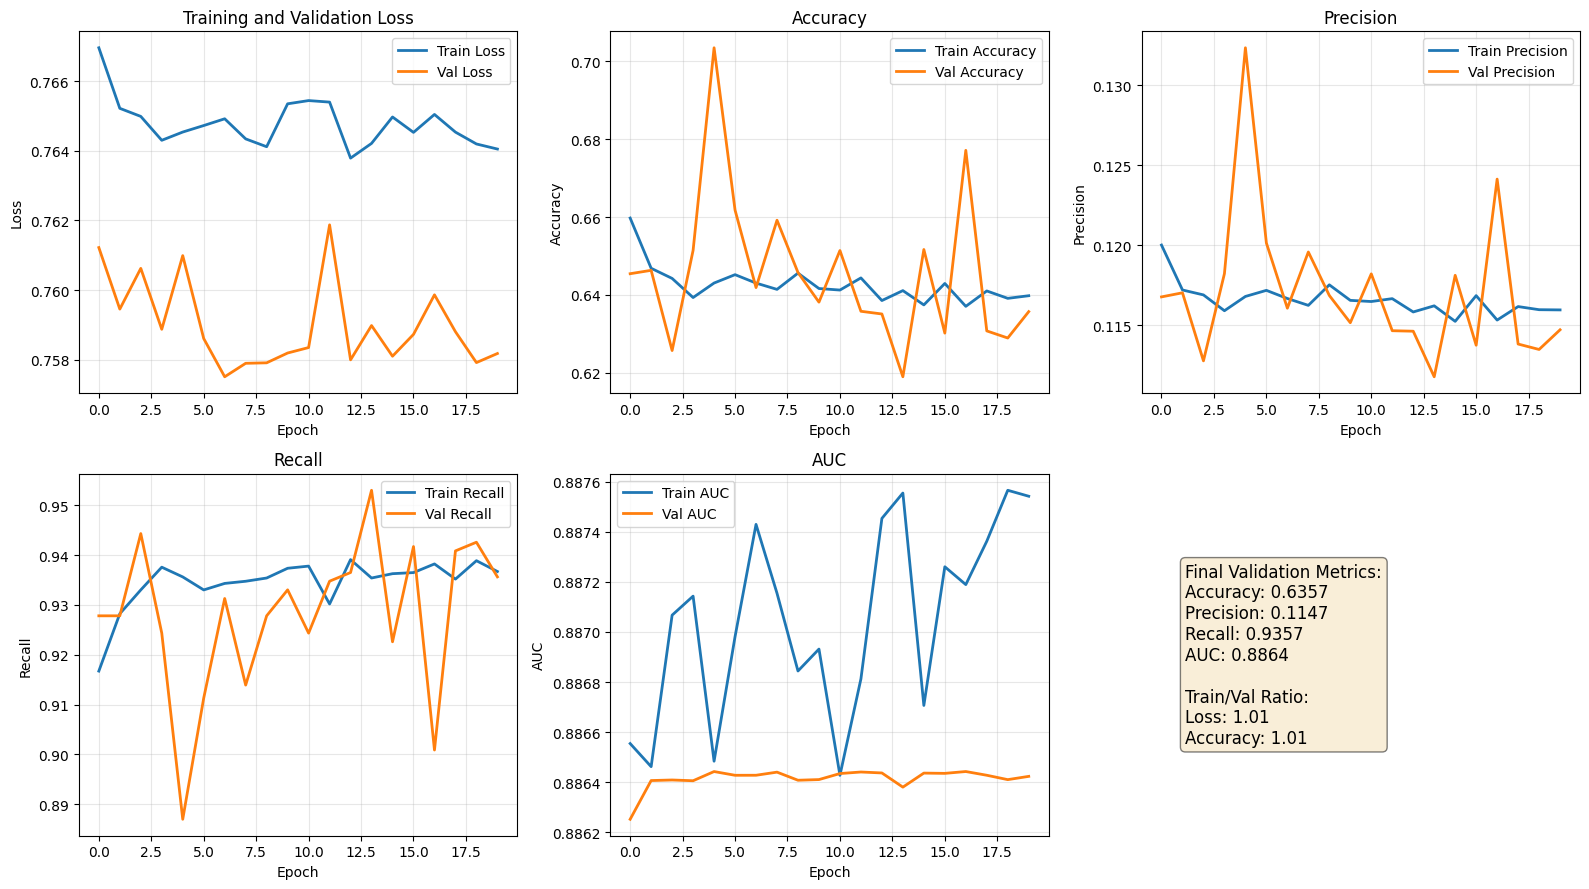

Testing: 100%|██████████| 770/770 [00:00<00:00, 887.24it/s]



TEST SET RESULTS:
Accuracy:  0.6322
Precision: 0.1145
Recall:    0.9436
AUC:       0.8878
F1-Score:  0.2042


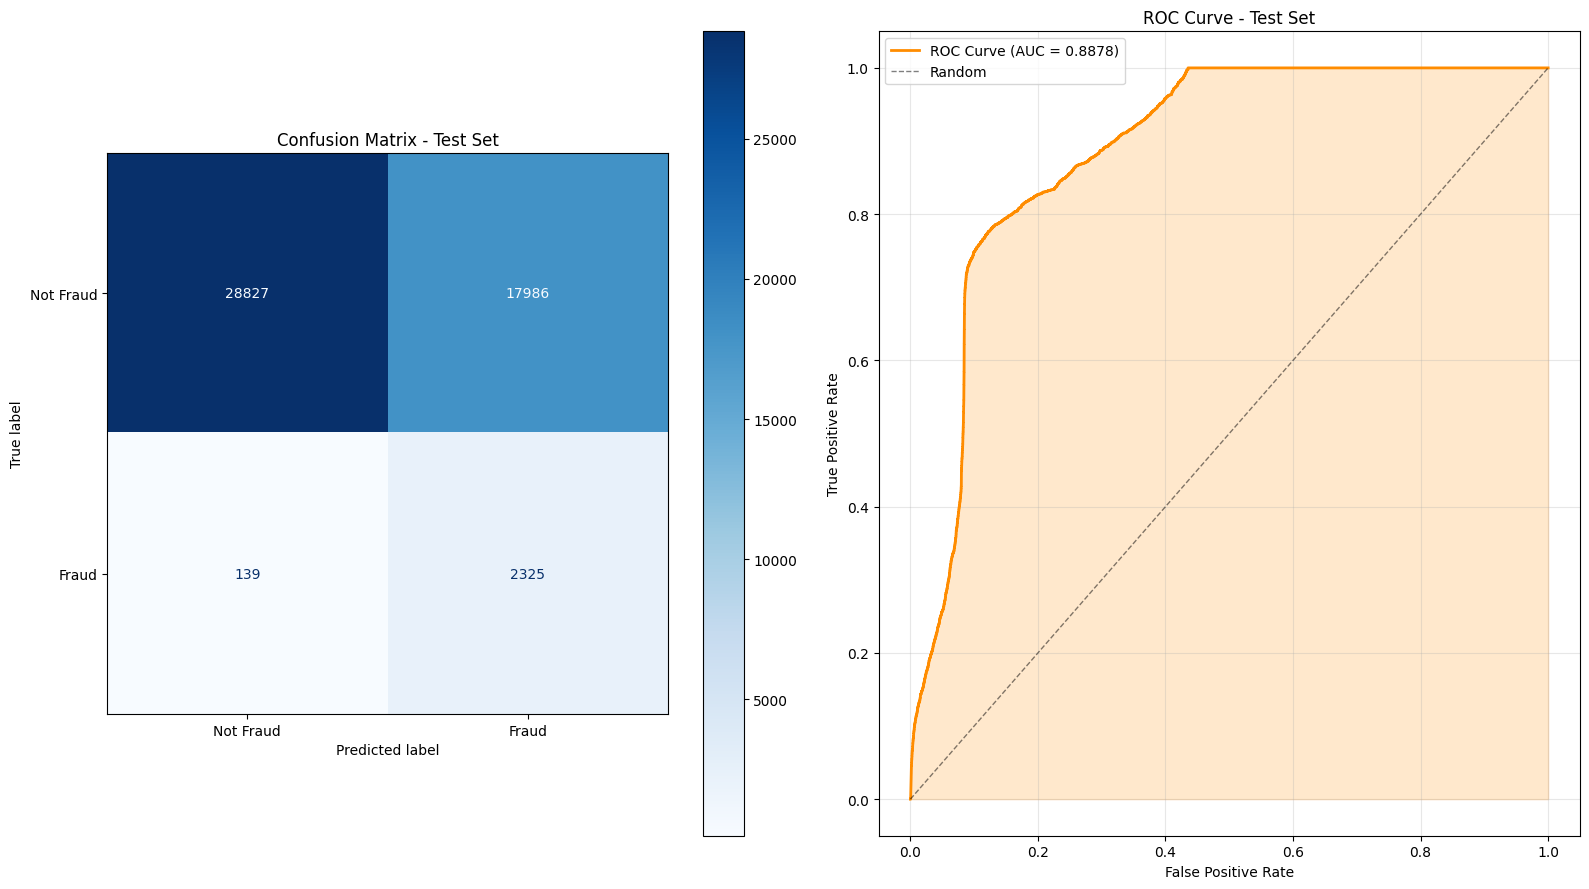

In [241]:
for weights in class_weights_grid:
    print('='*100 + '\n\n' + f'We are talking about weights {weights}\n\n' + '='*100)
    train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics, epoch_test_metrics = train_model_with_testing(
        model, 
        train_loader, 
        val_loader,
        test_loader,
        num_epochs=num_epochs, 
        learning_rate=learning_rate,
        test_every=test_every,
        class_weights=weights
    )
    best_auc_epoch, best_acc_epoch = plot_test_metrics_by_epoch(epoch_test_metrics)
    plot_training_results(train_losses, val_losses, train_metrics, val_metrics)
    test_accuracy, test_precision, test_recall, test_auc = test_model(model, test_loader)